# Time Series Forecasting

In [1]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

import pickle

plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()             # IAM role to use by SageMaker
region = sagemaker_session.boto_region_name

s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'time_series_forecast'    # prefix used for all data stored within the bucket
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")
print('image_name:', image_name)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


image_name: 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1


In [4]:
freq = '1D'
prediction_length = 7
context_length = 365

We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [5]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge',  # ml.p3.2xlarge  ml.c5.2xlarge
    base_job_name='deepar-demo-'+freq,
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [6]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",  # "20", or "400", or ...
    "early_stopping_patience": "40",  # “40” or "100"
    "mini_batch_size": "256",  # "256" or "512"
    "learning_rate": "1E-3",  # "1E-3" or "5E-4"
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
#     "num_dynamic_feat": "ignore"  # TODO ignore to not use dynamic_feat, auto to use dynamic_feat
}

In [7]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [ ]:
%%time

data_channels = {
    "train": ("{}/train/train_"+freq+".json").format(s3_data_path),
    "test": ("{}/test/test_"+freq+".json").format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

2021-04-19 11:00:50 Starting - Starting the training job..

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [42]:
from sagemaker.serializers import IdentitySerializer

In [43]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         #serializer=JSONSerializer(),
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [44]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

# job_name = estimator.latest_training_job.name
# job_name = 'deepar-demo-1H-2021-03-19-06-55-05-809'
# endpoint_name = sagemaker_session.endpoint_from_job(
#     job_name=job_name,
#     initial_instance_count=1,
#     instance_type='ml.m4.xlarge',
#     role=role
# )
# endpoint_name = 'deepar-demo-1H-2021-03-19-06-55-05-809'

# predictor = DeepARPredictor(endpoint_name, sagemaker_session, content_type="application/json")

---------------!

### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

In [45]:
# Restore timeseries and property_cat from json

def load_json(filename):
    data = []
    with open(filename, 'r') as fin:
        while True:
            line = fin.readline()
            if not line:
                break
            datai = json.loads(line)
            data.append(datai)
    return data

train = load_json('train_'+freq+'.json')
test = load_json('test_'+freq+'.json')
predict = load_json('predict_'+freq+'.json')
print(len(train[0]['target']), len(test[0]['target']), len(predict[0]['target']))

num_timeseries = len(train)
print(num_timeseries)

property_cat = []
ids = []
timeseries = []
dynamic_feats = []

for i in range(num_timeseries):        
    prediction_index = pd.date_range(start=predict[i]['start'], freq=freq, periods=len(predict[i]['target'])) 
    total_fee = pd.Series(data=predict[i]['target'], index=prediction_index)
    total_fee = total_fee.resample(freq).asfreq()
    timeseries.append(total_fee.astype(np.float32))
    
    dynamic_featj = []
    for j in range(len(predict[i]['dynamic_feat'])):
#         print(predict[i]['dynamic_feat'][j])
        dynamic_feat = pd.Series(data=predict[i]['dynamic_feat'][j], index=prediction_index)
        dynamic_feat = dynamic_feat.resample(freq).asfreq()
        dynamic_featj.append(dynamic_feat.astype(np.float32))
    print('dynamic_featj:', len(dynamic_featj[0]))
    dynamic_feats.append(dynamic_featj)
    
    ids.append(predict[i]['id'])
    property_cat.append(predict[i]['cat'])

288 360 432
96
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 432
dynamic_featj: 4

In [46]:
#quantiles = [0.1, 0.5, 0.9]
quantiles = [str(round(i*0.1, 1)) for i in range(1, 10)]
# print('quantiles:', quantiles)

Below we define a plotting function that queries the model and displays the forecast.

In [47]:
print(len(timeseries[0][start_dataset:end_test][:-1]))
dynamic_feat = []
for dynamic_featj in dynamic_feats[0]:
    dynamic_feat.append(dynamic_featj[start_dataset:end_predict].tolist())
result = predictor.predict(ts=timeseries[0][start_dataset:end_test][:-1], cat=property_cat[0], dynamic_feat=dynamic_feat, quantiles=quantiles)
print(result)

360
                       0.1    0.2    0.3    0.4   0.5   0.6   0.7   0.8   0.9
2020-11-28 00:00:00 -0.033 -0.010  0.002  0.011 0.023 0.032 0.041 0.056 0.074
2020-11-28 01:00:00 -0.018 -0.002  0.016  0.026 0.038 0.046 0.059 0.074 0.085
2020-11-28 02:00:00 -0.002  0.014  0.022  0.039 0.050 0.060 0.065 0.081 0.129
2020-11-28 03:00:00 -0.019  0.005  0.024  0.039 0.059 0.070 0.079 0.099 0.130
2020-11-28 04:00:00 -0.030  0.002  0.024  0.040 0.049 0.061 0.075 0.091 0.127
...                    ...    ...    ...    ...   ...   ...   ...   ...   ...
2020-11-30 19:00:00 -0.073 -0.012  0.053  0.130 0.225 0.269 0.409 0.495 0.821
2020-11-30 20:00:00 -0.107 -0.068 -0.011  0.027 0.070 0.098 0.176 0.240 0.546
2020-11-30 21:00:00 -0.148 -0.082 -0.051 -0.031 0.002 0.053 0.103 0.130 0.294
2020-11-30 22:00:00 -0.063 -0.042 -0.027 -0.002 0.009 0.039 0.064 0.127 0.197
2020-11-30 23:00:00 -0.079 -0.037 -0.004  0.011 0.025 0.048 0.070 0.129 0.261

[72 rows x 9 columns]


We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [48]:
%%time

preds = []

for i, ts_dict in enumerate(timeseries):
    ts = ts_dict[start_dataset:end_test][:-1]
#     print('ts:', len(ts))
#     if ts.shape[0] == 0:
#         preds.append(None)
#         continue
    cat=property_cat[i]
    dynamic_feat = []
    for dynamic_featj in dynamic_feats[i]:
        dynamic_feat.append(dynamic_featj[start_dataset:end_predict].tolist())
#     print('dynamic_feat:', len(dynamic_feat[0]), len(dynamic_feat[1]))
#     print('dynamic_feat:', dynamic_feat)
#     try:
    pred = predictor.predict(ts=ts, cat=cat, dynamic_feat=dynamic_feat, quantiles=quantiles)
    preds.append(pred)
#     except Exception as e:
#         print(e)
#         preds.append(None)

CPU times: user 489 ms, sys: 11.9 ms, total: 500 ms
Wall time: 13 s


In [49]:
y_labels = []
y_preds = []
target_quantile='0.5'  # '0.5', '0.6'

for i in range(len(timeseries)):
    if preds[i] is None:
        continue
        
    s = timeseries[i][start_dataset:end_predict].fillna(0)
    y_label = timeseries[i][start_predict:end_predict].fillna(0)
    y_pred = preds[i][target_quantile]
    
    y_labels.append(y_label)
    y_preds.append(y_pred)

In [50]:
from sklearn import metrics

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)/100

def eval_metric(a, f):
#     print('a:', a)
#     print('f:', f)
    new_a = []
    new_f = []
    for i in range(len(a)):
        if a[i] != 0:
            new_a.append(a[i])
            new_f.append(f[i])
    new_a = np.array(a)
    new_f = np.array(f)
#     print('new_a:', new_a)
#     print('new_f:', new_f)
    return np.mean((new_f-new_a)/new_a)

def eval_metric2(a, f):
#     print('a:', a)
#     print('f:', f)
    new_a = []
    new_f = []
    for i in range(len(a)):
        if a[i] != 0:
            new_a.append(a[i])
            new_f.append(f[i])
    new_a = np.array(a)
    new_f = np.array(f)
#     print('new_a:', new_a)
#     print('new_f:', new_f)
    return np.mean(np.abs(new_f-new_a)/np.abs(new_a))

In [51]:
print('y_labels:', len(y_labels))
print('y_preds:', len(y_preds))
y_labels = np.array(y_labels)
y_preds = np.array(y_preds)
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_labels, y_preds)))
print("MAE:",metrics.mean_absolute_error(y_labels, y_preds))
print("Target Mean:",y_labels.mean())
smape_score = 0
smapes = []
rmses = []
maes = []
means = []
for i in range(y_labels.shape[0]):
    smapei = smape(y_labels[i], y_preds[i])
    rmsei = np.sqrt(metrics.mean_squared_error(y_labels[i], y_preds[i]))
    maei = metrics.mean_absolute_error(y_labels[i], y_preds[i])
    smape_score += smapei
    smapes.append(smapei)
    rmses.append(rmsei)
    maes.append(maei)
    means.append(y_labels[i].mean())
print("sMAPE:",smape_score/y_labels.shape[0])

y_labels: 96
y_preds: 96
RMSE: 0.6262430202718761
MAE: 0.20980477619224328
Target Mean: 0.6460343
sMAPE: 0.772176658215343


In [52]:
y_sum_labels = np.sum(y_labels, axis=0)
y_sum_preds = np.sum(y_preds, axis=0)
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_sum_labels, y_sum_preds)))
print("MAE:",metrics.mean_absolute_error(y_sum_labels, y_sum_preds))
print("SMAPE:", smape(y_sum_labels, y_sum_preds))
print("EVAL METRIC:", eval_metric(y_sum_labels, y_sum_preds))
print("EVAL METRIC2:", eval_metric2(y_sum_labels, y_sum_preds))
print("Target Mean:",y_sum_labels.mean())

RMSE: 10.967117947256948
MAE: 9.364922431697043
SMAPE: 0.1640635411350306
EVAL METRIC: -0.09015363285105742
EVAL METRIC2: 0.15265336298278462
Target Mean: 62.019295


In [53]:
y_sum_labels

array([64.03653 , 68.537895, 72.6148  , 75.08879 , 80.31598 , 80.550735,
       71.82529 , 64.14833 , 62.98473 , 69.14499 , 69.1782  , 67.862076,
       67.34141 , 69.71132 , 72.6077  , 63.14518 , 74.19968 , 76.709595,
       70.1675  , 62.231792, 61.378033, 61.29847 , 59.694378, 68.15666 ,
       52.393673, 54.676167, 54.79268 , 57.069164, 54.10109 , 55.644165,
       59.08216 , 55.607006, 54.21974 , 49.95792 , 45.879837, 48.116917,
       55.853085, 52.04791 , 51.045753, 51.070316, 58.73992 , 54.553745,
       49.913155, 46.501835, 55.94517 , 53.68184 , 60.800663, 54.393505,
       59.13895 , 60.343754, 58.32816 , 59.44729 , 58.592297, 61.147327,
       58.439465, 58.601593, 60.40925 , 65.91396 , 60.67971 , 57.046337,
       64.00213 , 65.80212 , 65.126465, 59.45954 , 71.807236, 73.677025,
       68.59235 , 66.4498  , 66.05583 , 70.53667 , 66.88604 , 69.88842 ],
      dtype=float32)

In [54]:
y_sum_preds

array([62.64860113, 61.33450111, 59.94997722, 60.46834604, 59.03362768,
       57.58463133, 58.31507747, 56.70070278, 56.33415687, 60.16605405,
       63.05586471, 66.22644385, 65.33261161, 67.41426208, 66.30133522,
       67.07510592, 67.5366581 , 67.23893502, 63.27375902, 55.66465597,
       56.1127808 , 57.62597637, 55.03052543, 52.89023178, 45.71091458,
       42.18673572, 43.83094573, 43.61323639, 46.87485855, 48.08384276,
       49.35809937, 49.28707517, 49.73232424, 51.74529797, 51.42082201,
       52.49183173, 59.19083568, 64.79538349, 65.92302169, 66.61539428,
       66.43790312, 62.68972758, 64.49562754, 59.04975029, 58.3969206 ,
       60.83721855, 56.88557643, 54.88609941, 47.96185849, 44.81041914,
       41.79981718, 41.09548847, 40.5604985 , 40.80772944, 41.18996885,
       40.33299771, 41.15649111, 42.71400918, 45.85637723, 47.90342073,
       51.37903549, 53.9066802 , 57.69924243, 60.13817977, 62.42341797,
       64.94605585, 63.56297924, 61.77543769, 62.13319416, 63.53

In [55]:
np.savetxt('result_sagemaker_deepar.csv', y_preds, delimiter=',')
# np.savetxt('result_sagemaker_deepar_without_dynamic_feat.csv', y_preds, delimiter=',')

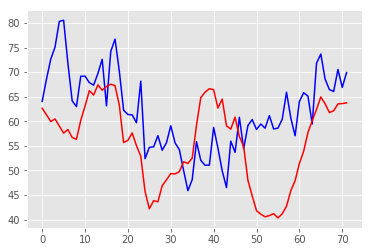

In [56]:
plt.plot(y_sum_labels,"b-",label="label")
plt.plot(y_sum_preds,"r-",label="predict")
plt.show()

i: 0 sd001
RMSE: 0.2719893049624248
MAE: 0.19279491889215455
Target Mean: 0.374694287776947
sMAPE: 0.6451169602631254
                     y_pred  y_label
2020-11-28 00:00:00   0.023    0.028
2020-11-28 01:00:00   0.038    0.028
2020-11-28 02:00:00   0.050    0.028
2020-11-28 03:00:00   0.059    0.042
2020-11-28 04:00:00   0.049    0.014
...                     ...      ...
2020-11-30 19:00:00   0.225    0.740
2020-11-30 20:00:00   0.070    0.341
2020-11-30 21:00:00   0.002    0.042
2020-11-30 22:00:00   0.009    0.028
2020-11-30 23:00:00   0.025    0.014

[72 rows x 2 columns]


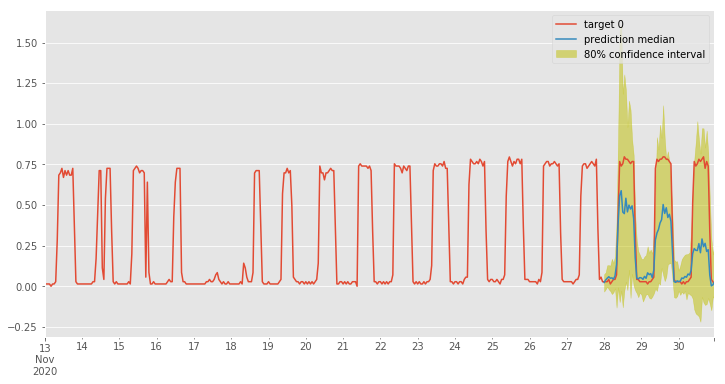

i: 1 sd002
RMSE: 0.14695553284119364
MAE: 0.11871477257977131
Target Mean: 0.5057499408721924
sMAPE: 0.2521870998893092
                     y_pred  y_label
2020-11-28 00:00:00   0.411    0.342
2020-11-28 01:00:00   0.432    0.306
2020-11-28 02:00:00   0.453    0.378
2020-11-28 03:00:00   0.435    0.486
2020-11-28 04:00:00   0.416    0.576
...                     ...      ...
2020-11-30 19:00:00   0.554    0.540
2020-11-30 20:00:00   0.596    0.468
2020-11-30 21:00:00   0.556    0.648
2020-11-30 22:00:00   0.494    0.468
2020-11-30 23:00:00   0.459    0.504

[72 rows x 2 columns]


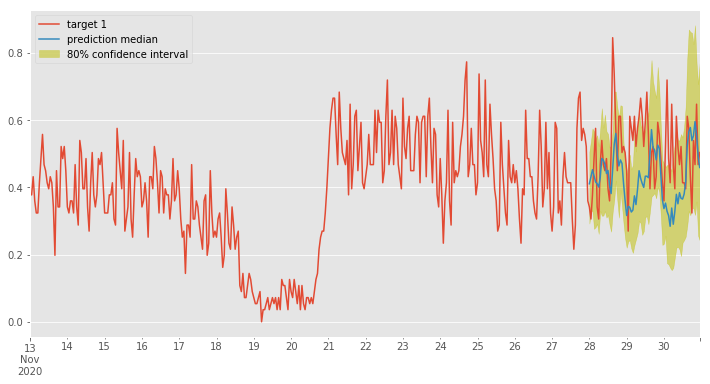

i: 2 sd003
RMSE: 0.03565293795693097
MAE: 0.026152068771310537
Target Mean: 0.008625002577900887
sMAPE: 1.101505929587601
                     y_pred  y_label
2020-11-28 00:00:00   0.079    0.009
2020-11-28 01:00:00   0.078    0.009
2020-11-28 02:00:00   0.104    0.009
2020-11-28 03:00:00   0.087    0.009
2020-11-28 04:00:00   0.095    0.009
...                     ...      ...
2020-11-30 19:00:00   0.012    0.009
2020-11-30 20:00:00   0.008    0.009
2020-11-30 21:00:00   0.007    0.000
2020-11-30 22:00:00   0.024    0.009
2020-11-30 23:00:00   0.037    0.009

[72 rows x 2 columns]


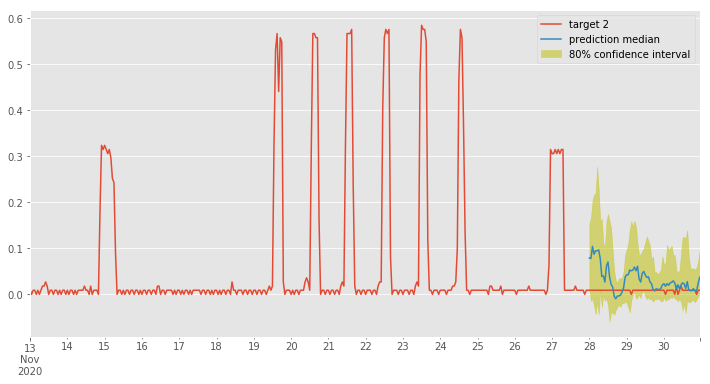

i: 3 sd004
RMSE: 0.027611557523067085
MAE: 0.025452684175
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.018    0.000
2020-11-28 01:00:00  -0.020    0.000
2020-11-28 02:00:00  -0.022    0.000
2020-11-28 03:00:00  -0.024    0.000
2020-11-28 04:00:00  -0.026    0.000
...                     ...      ...
2020-11-30 19:00:00  -0.008    0.000
2020-11-30 20:00:00  -0.011    0.000
2020-11-30 21:00:00  -0.009    0.000
2020-11-30 22:00:00  -0.009    0.000
2020-11-30 23:00:00  -0.006    0.000

[72 rows x 2 columns]


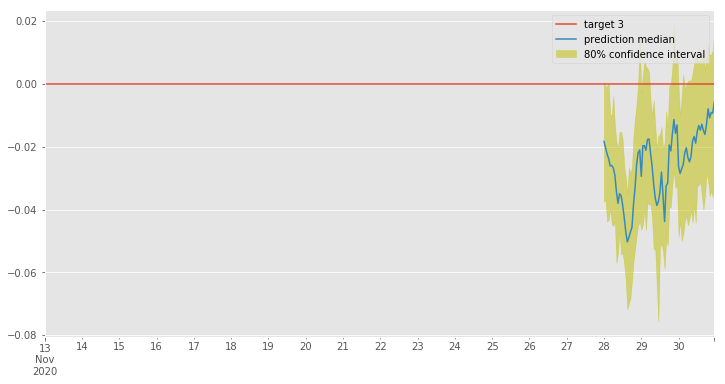

i: 4 sd005
RMSE: 0.006576680209908997
MAE: 0.003846915920848107
Target Mean: 0.0011249999515712261
sMAPE: 1.9877006775059962
                     y_pred  y_label
2020-11-28 00:00:00   0.003    0.000
2020-11-28 01:00:00   0.002    0.000
2020-11-28 02:00:00   0.002    0.000
2020-11-28 03:00:00   0.002    0.000
2020-11-28 04:00:00   0.000    0.000
...                     ...      ...
2020-11-30 19:00:00   0.003    0.000
2020-11-30 20:00:00  -0.000    0.000
2020-11-30 21:00:00   0.001    0.000
2020-11-30 22:00:00   0.001    0.000
2020-11-30 23:00:00   0.001    0.000

[72 rows x 2 columns]


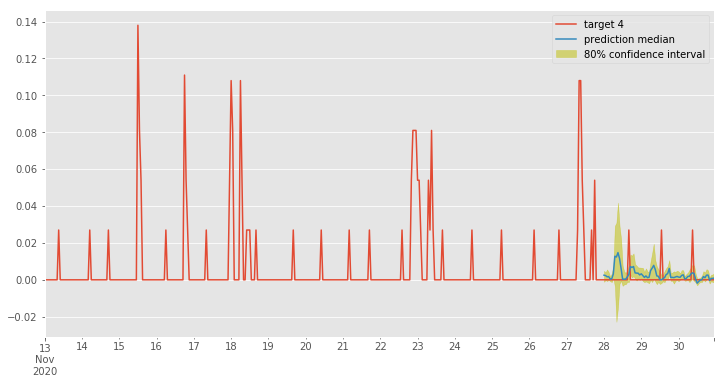

i: 5 sd006
RMSE: 0.10146525752499203
MAE: 0.06872997059984352
Target Mean: 0.16444434225559235
sMAPE: 0.43573894621670367
                     y_pred  y_label
2020-11-28 00:00:00   0.084    0.080
2020-11-28 01:00:00   0.083    0.120
2020-11-28 02:00:00   0.080    0.120
2020-11-28 03:00:00   0.070    0.120
2020-11-28 04:00:00   0.074    0.080
...                     ...      ...
2020-11-30 19:00:00   0.088    0.120
2020-11-30 20:00:00   0.078    0.120
2020-11-30 21:00:00   0.087    0.160
2020-11-30 22:00:00   0.083    0.120
2020-11-30 23:00:00   0.084    0.120

[72 rows x 2 columns]


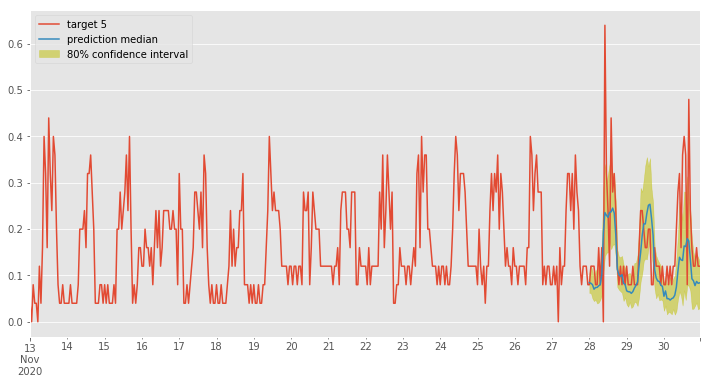

i: 6 sd007
RMSE: 0.0027775710592258126
MAE: 0.0022093080416666667
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00   0.001    0.000
2020-11-28 01:00:00   0.004    0.000
2020-11-28 02:00:00  -0.000    0.000
2020-11-28 03:00:00   0.000    0.000
2020-11-28 04:00:00   0.001    0.000
...                     ...      ...
2020-11-30 19:00:00   0.002    0.000
2020-11-30 20:00:00   0.003    0.000
2020-11-30 21:00:00   0.002    0.000
2020-11-30 22:00:00   0.002    0.000
2020-11-30 23:00:00   0.007    0.000

[72 rows x 2 columns]


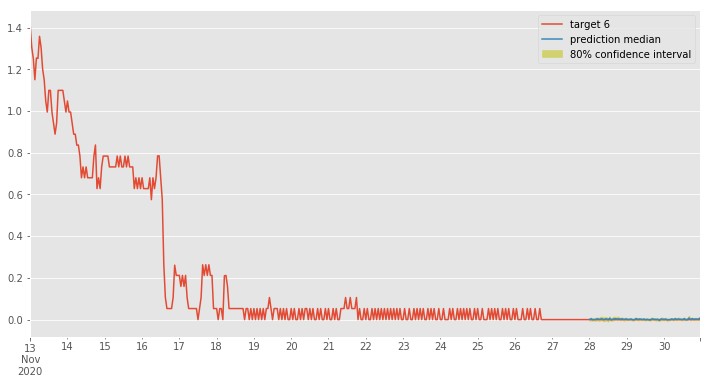

i: 7 sd008
RMSE: 0.0008823569832877665
MAE: 0.0006781699805555556
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.000    0.000
2020-11-28 01:00:00  -0.000    0.000
2020-11-28 02:00:00   0.000    0.000
2020-11-28 03:00:00  -0.000    0.000
2020-11-28 04:00:00  -0.000    0.000
...                     ...      ...
2020-11-30 19:00:00   0.002    0.000
2020-11-30 20:00:00   0.002    0.000
2020-11-30 21:00:00   0.002    0.000
2020-11-30 22:00:00   0.002    0.000
2020-11-30 23:00:00   0.001    0.000

[72 rows x 2 columns]


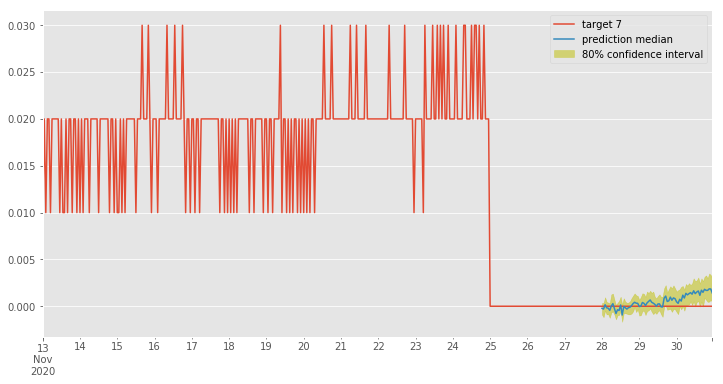

i: 8 sd009
RMSE: 0.043306893696397133
MAE: 0.03893455542615706
Target Mean: 0.07745836675167084
sMAPE: 0.6389935710508977
                     y_pred  y_label
2020-11-28 00:00:00   0.092    0.117
2020-11-28 01:00:00   0.095    0.078
2020-11-28 02:00:00   0.099    0.039
2020-11-28 03:00:00   0.099    0.078
2020-11-28 04:00:00   0.079    0.039
...                     ...      ...
2020-11-30 19:00:00   0.033    0.078
2020-11-30 20:00:00   0.036    0.078
2020-11-30 21:00:00   0.029    0.078
2020-11-30 22:00:00   0.036    0.078
2020-11-30 23:00:00   0.039    0.039

[72 rows x 2 columns]


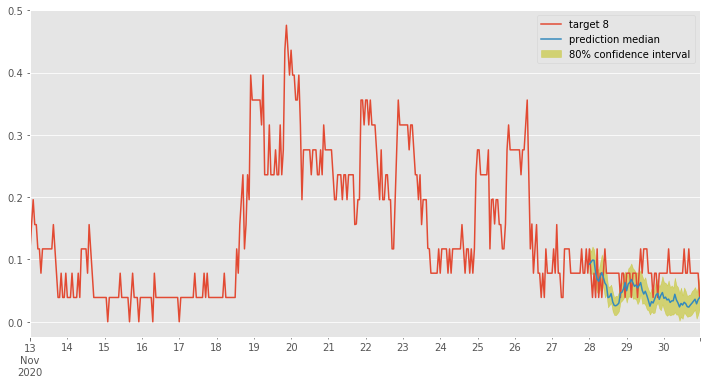

i: 9 sd010
RMSE: 0.2161307268504473
MAE: 0.1740588691171867
Target Mean: 0.1231018602848053
sMAPE: 0.9329102830229877
                     y_pred  y_label
2020-11-28 00:00:00  -0.019    0.077
2020-11-28 01:00:00  -0.100    0.103
2020-11-28 02:00:00  -0.117    0.077
2020-11-28 03:00:00  -0.177    0.100
2020-11-28 04:00:00  -0.169    0.103
...                     ...      ...
2020-11-30 19:00:00   0.587    0.153
2020-11-30 20:00:00   0.585    0.103
2020-11-30 21:00:00   0.587    0.077
2020-11-30 22:00:00   0.574    0.077
2020-11-30 23:00:00   0.569    0.100

[72 rows x 2 columns]


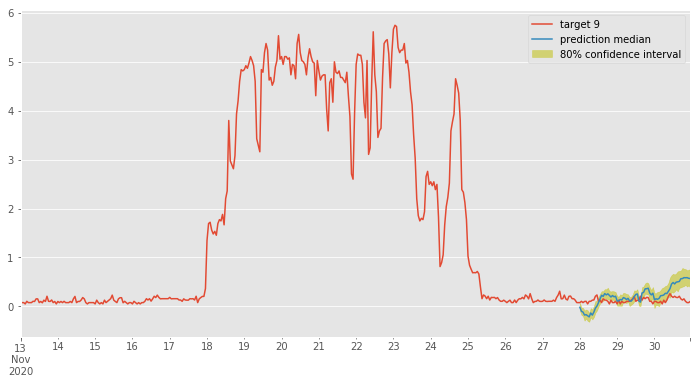

i: 10 sd011
RMSE: 0.06487968213153701
MAE: 0.05597617104866294
Target Mean: 0.2615833282470703
sMAPE: 0.25066700075265075
                     y_pred  y_label
2020-11-28 00:00:00   0.242    0.258
2020-11-28 01:00:00   0.223    0.246
2020-11-28 02:00:00   0.230    0.252
2020-11-28 03:00:00   0.209    0.246
2020-11-28 04:00:00   0.213    0.246
...                     ...      ...
2020-11-30 19:00:00   0.215    0.258
2020-11-30 20:00:00   0.225    0.258
2020-11-30 21:00:00   0.211    0.258
2020-11-30 22:00:00   0.218    0.264
2020-11-30 23:00:00   0.218    0.258

[72 rows x 2 columns]


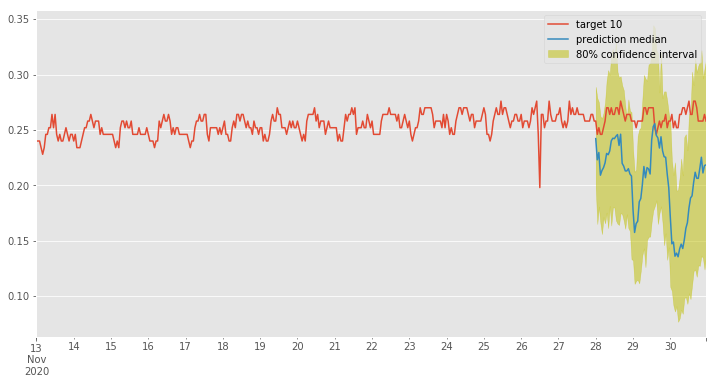

i: 11 sd012
RMSE: 0.03395279655490258
MAE: 0.03207378125
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.021    0.000
2020-11-28 01:00:00  -0.024    0.000
2020-11-28 02:00:00  -0.024    0.000
2020-11-28 03:00:00  -0.027    0.000
2020-11-28 04:00:00  -0.025    0.000
...                     ...      ...
2020-11-30 19:00:00  -0.023    0.000
2020-11-30 20:00:00  -0.021    0.000
2020-11-30 21:00:00  -0.023    0.000
2020-11-30 22:00:00  -0.022    0.000
2020-11-30 23:00:00  -0.018    0.000

[72 rows x 2 columns]


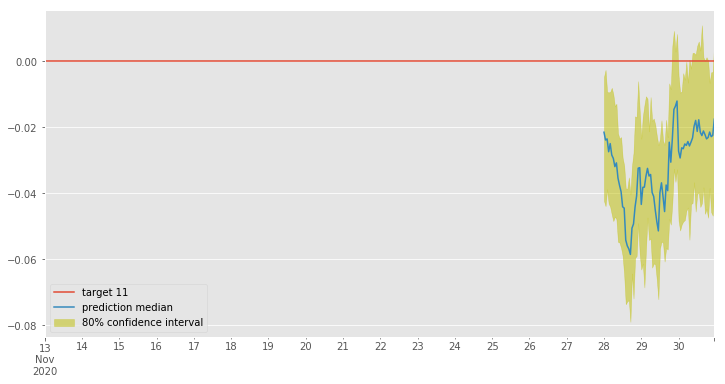

i: 12 sd013
RMSE: 0.1594888792600095
MAE: 0.1342927333391281
Target Mean: 0.796805739402771
sMAPE: 0.17203925725928948
                     y_pred  y_label
2020-11-28 00:00:00   0.842    0.885
2020-11-28 01:00:00   0.843    0.885
2020-11-28 02:00:00   0.820    0.895
2020-11-28 03:00:00   0.827    0.885
2020-11-28 04:00:00   0.839    0.885
...                     ...      ...
2020-11-30 19:00:00   0.906    0.705
2020-11-30 20:00:00   0.925    0.755
2020-11-30 21:00:00   0.890    0.825
2020-11-30 22:00:00   0.925    0.800
2020-11-30 23:00:00   0.921    0.820

[72 rows x 2 columns]


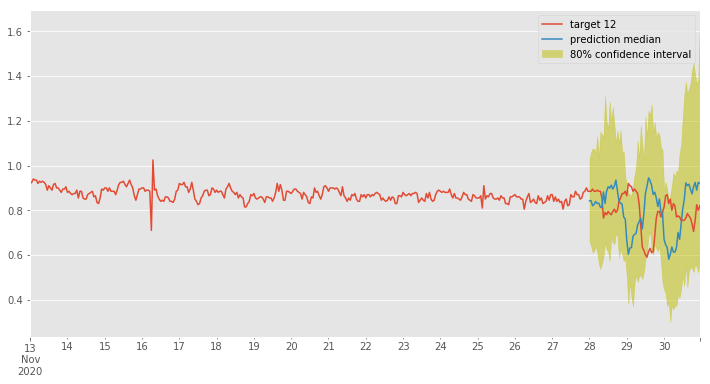

i: 13 sd014
RMSE: 0.6063657424685648
MAE: 0.4820505595858376
Target Mean: 1.9991250038146973
sMAPE: 0.24145401993551122
                     y_pred  y_label
2020-11-28 00:00:00   2.185    1.314
2020-11-28 01:00:00   2.146    1.971
2020-11-28 02:00:00   2.093    1.971
2020-11-28 03:00:00   2.214    2.628
2020-11-28 04:00:00   2.045    2.631
...                     ...      ...
2020-11-30 19:00:00   2.222    1.971
2020-11-30 20:00:00   1.986    1.971
2020-11-30 21:00:00   2.110    1.971
2020-11-30 22:00:00   2.201    1.971
2020-11-30 23:00:00   2.058    1.971

[72 rows x 2 columns]


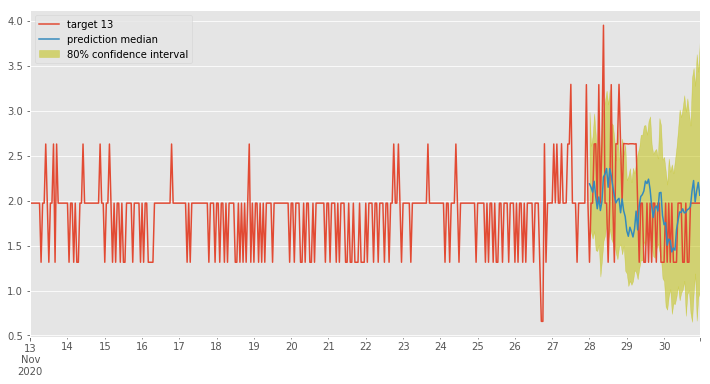

i: 14 sd015
RMSE: 0.41091561121489545
MAE: 0.34027729059249784
Target Mean: 1.4211946725845337
sMAPE: 0.28372621573595624
                     y_pred  y_label
2020-11-28 00:00:00   1.243    1.087
2020-11-28 01:00:00   1.054    0.878
2020-11-28 02:00:00   0.856    1.035
2020-11-28 03:00:00   0.746    0.881
2020-11-28 04:00:00   0.734    1.038
...                     ...      ...
2020-11-30 19:00:00   1.539    2.036
2020-11-30 20:00:00   1.637    1.931
2020-11-30 21:00:00   1.523    1.827
2020-11-30 22:00:00   1.550    1.352
2020-11-30 23:00:00   1.421    1.038

[72 rows x 2 columns]


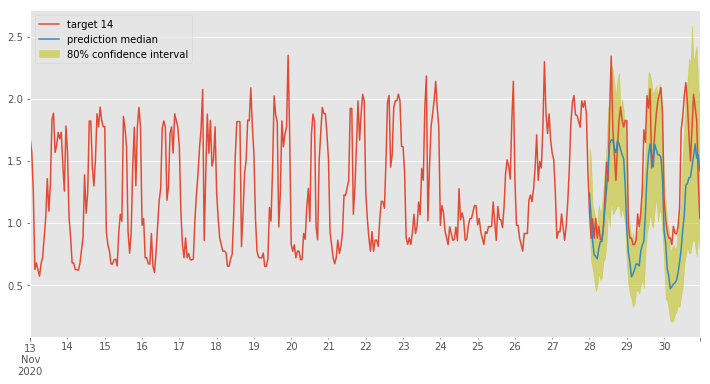

i: 15 sd016
RMSE: 0.24191763121530452
MAE: 0.1456914567670307
Target Mean: 0.22291654348373413
sMAPE: 1.1117492589551277
                     y_pred  y_label
2020-11-28 00:00:00   0.353    0.634
2020-11-28 01:00:00   0.324    0.728
2020-11-28 02:00:00   0.355    0.567
2020-11-28 03:00:00   0.355    0.701
2020-11-28 04:00:00   0.292    0.822
...                     ...      ...
2020-11-30 19:00:00   0.024    0.000
2020-11-30 20:00:00   0.028    0.013
2020-11-30 21:00:00   0.054    0.013
2020-11-30 22:00:00   0.108    0.485
2020-11-30 23:00:00   0.156    0.566

[72 rows x 2 columns]


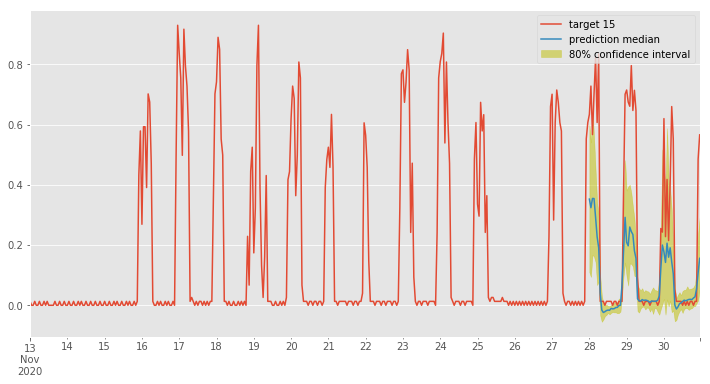

i: 16 sd017
RMSE: 0.012416760259515722
MAE: 0.008380774721735046
Target Mean: 0.009111111052334309
sMAPE: 1.639018838115166
                     y_pred  y_label
2020-11-28 00:00:00   0.002    0.006
2020-11-28 01:00:00   0.002    0.000
2020-11-28 02:00:00   0.002    0.006
2020-11-28 03:00:00   0.002    0.000
2020-11-28 04:00:00   0.001    0.006
...                     ...      ...
2020-11-30 19:00:00   0.001    0.006
2020-11-30 20:00:00   0.001    0.006
2020-11-30 21:00:00   0.001    0.006
2020-11-30 22:00:00   0.001    0.000
2020-11-30 23:00:00   0.001    0.006

[72 rows x 2 columns]


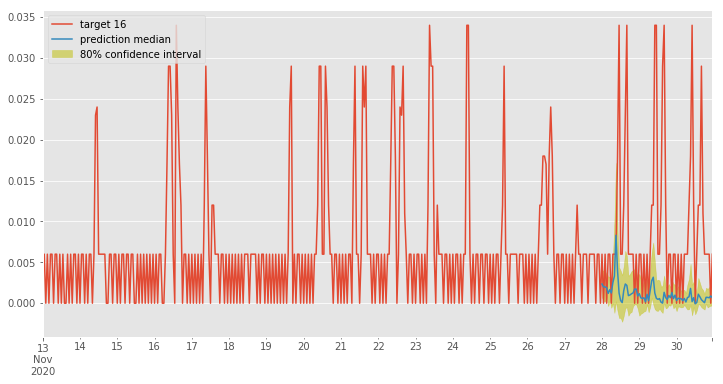

i: 17 sd018
RMSE: 0.6756206866174252
MAE: 0.5579329431066342
Target Mean: 2.359194278717041
sMAPE: 0.31136584553243424
                     y_pred  y_label
2020-11-28 00:00:00   2.287    2.398
2020-11-28 01:00:00   2.227    1.838
2020-11-28 02:00:00   2.611    2.478
2020-11-28 03:00:00   2.645    2.638
2020-11-28 04:00:00   3.022    3.078
...                     ...      ...
2020-11-30 19:00:00   1.316    0.000
2020-11-30 20:00:00   2.019    2.918
2020-11-30 21:00:00   2.131    2.678
2020-11-30 22:00:00   2.045    2.358
2020-11-30 23:00:00   1.881    2.078

[72 rows x 2 columns]


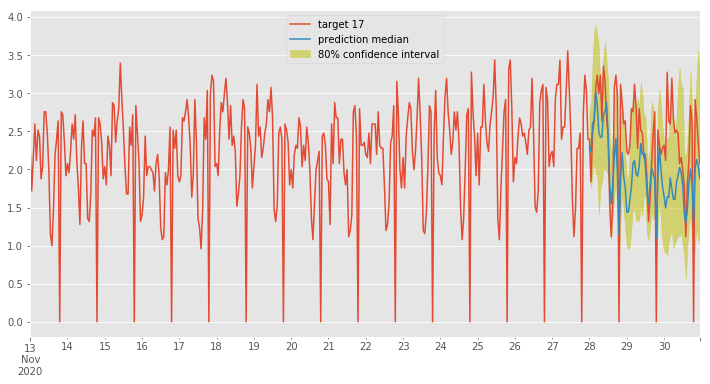

i: 18 sd020
RMSE: 0.061376015943274416
MAE: 0.05215571263246241
Target Mean: 0.15711107850074768
sMAPE: 0.3956148224825163
                     y_pred  y_label
2020-11-28 00:00:00   0.120    0.116
2020-11-28 01:00:00   0.123    0.146
2020-11-28 02:00:00   0.099    0.116
2020-11-28 03:00:00   0.085    0.116
2020-11-28 04:00:00   0.082    0.146
...                     ...      ...
2020-11-30 19:00:00   0.107    0.146
2020-11-30 20:00:00   0.107    0.176
2020-11-30 21:00:00   0.115    0.206
2020-11-30 22:00:00   0.104    0.176
2020-11-30 23:00:00   0.118    0.146

[72 rows x 2 columns]


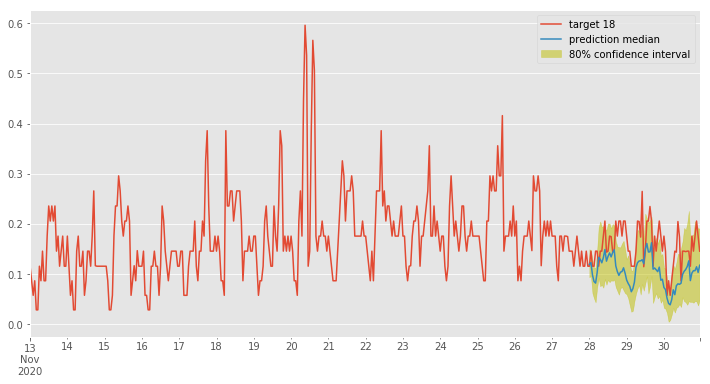

i: 19 sd022
RMSE: 0.01642192478630809
MAE: 0.015022313695833336
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.003    0.000
2020-11-28 01:00:00   0.003    0.000
2020-11-28 02:00:00   0.007    0.000
2020-11-28 03:00:00   0.007    0.000
2020-11-28 04:00:00   0.012    0.000
...                     ...      ...
2020-11-30 19:00:00   0.018    0.000
2020-11-30 20:00:00   0.010    0.000
2020-11-30 21:00:00   0.007    0.000
2020-11-30 22:00:00   0.008    0.000
2020-11-30 23:00:00   0.012    0.000

[72 rows x 2 columns]


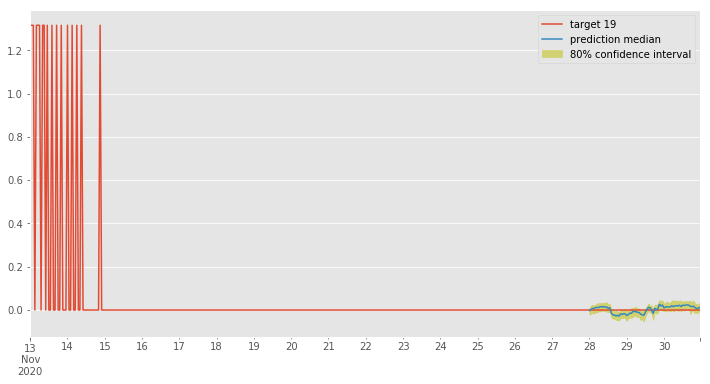

i: 20 sd023
RMSE: 0.17540599349855976
MAE: 0.1184037290476348
Target Mean: 0.25223612785339355
sMAPE: 0.5039110396671292
                     y_pred  y_label
2020-11-28 00:00:00   0.107    0.126
2020-11-28 01:00:00   0.094    0.100
2020-11-28 02:00:00   0.102    0.126
2020-11-28 03:00:00   0.106    0.126
2020-11-28 04:00:00   0.105    0.100
...                     ...      ...
2020-11-30 19:00:00   0.072    0.126
2020-11-30 20:00:00   0.075    0.100
2020-11-30 21:00:00   0.069    0.100
2020-11-30 22:00:00   0.068    0.126
2020-11-30 23:00:00   0.069    0.126

[72 rows x 2 columns]


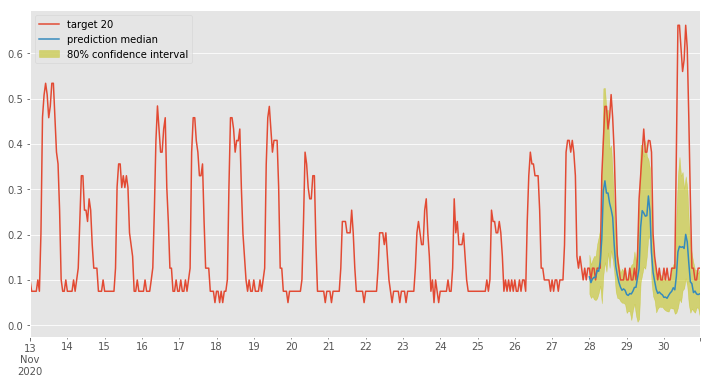

i: 21 sd025
RMSE: 0.8580993060673014
MAE: 0.6687373305770399
Target Mean: 1.3661249876022339
sMAPE: 0.5431326557831303
                     y_pred  y_label
2020-11-28 00:00:00   3.075    3.348
2020-11-28 01:00:00   2.859    3.108
2020-11-28 02:00:00   2.616    2.988
2020-11-28 03:00:00   2.625    3.348
2020-11-28 04:00:00   2.563    2.928
...                     ...      ...
2020-11-30 19:00:00   1.157    0.414
2020-11-30 20:00:00   1.590    2.508
2020-11-30 21:00:00   2.063    3.168
2020-11-30 22:00:00   2.223    3.828
2020-11-30 23:00:00   2.486    4.068

[72 rows x 2 columns]


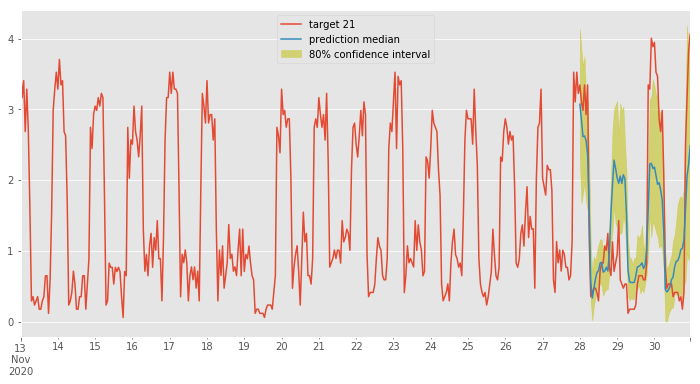

i: 22 sd026
RMSE: 0.036052639972682196
MAE: 0.034063770487500006
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.026    0.000
2020-11-28 01:00:00  -0.029    0.000
2020-11-28 02:00:00  -0.027    0.000
2020-11-28 03:00:00  -0.032    0.000
2020-11-28 04:00:00  -0.030    0.000
...                     ...      ...
2020-11-30 19:00:00  -0.024    0.000
2020-11-30 20:00:00  -0.023    0.000
2020-11-30 21:00:00  -0.022    0.000
2020-11-30 22:00:00  -0.022    0.000
2020-11-30 23:00:00  -0.017    0.000

[72 rows x 2 columns]


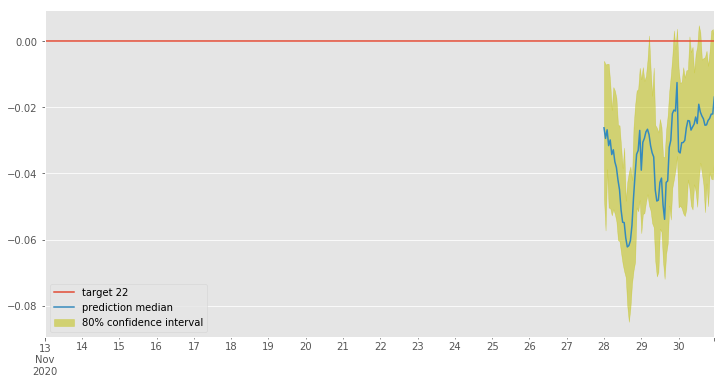

i: 23 sd027
RMSE: 0.022974862114942984
MAE: 0.017879766643055555
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.017    0.000
2020-11-28 01:00:00  -0.017    0.000
2020-11-28 02:00:00  -0.020    0.000
2020-11-28 03:00:00  -0.021    0.000
2020-11-28 04:00:00  -0.022    0.000
...                     ...      ...
2020-11-30 19:00:00  -0.001    0.000
2020-11-30 20:00:00   0.001    0.000
2020-11-30 21:00:00   0.007    0.000
2020-11-30 22:00:00   0.001    0.000
2020-11-30 23:00:00   0.007    0.000

[72 rows x 2 columns]


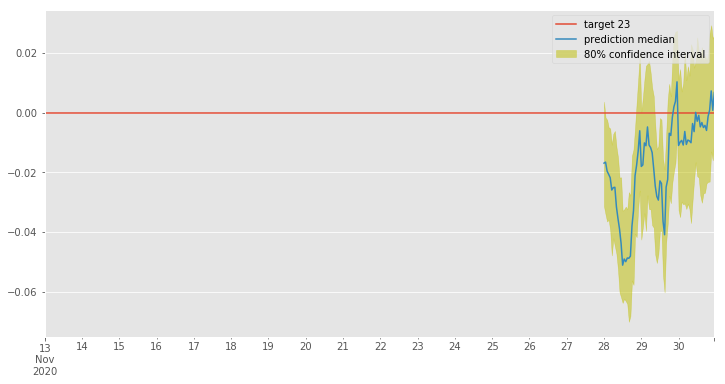

i: 24 sd028
RMSE: 0.06552471642129516
MAE: 0.05782722399813944
Target Mean: 0.07383333146572113
sMAPE: 0.734645458028144
                     y_pred  y_label
2020-11-28 00:00:00   0.130    0.206
2020-11-28 01:00:00   0.104    0.213
2020-11-28 02:00:00   0.092    0.044
2020-11-28 03:00:00   0.074    0.028
2020-11-28 04:00:00   0.067    0.028
...                     ...      ...
2020-11-30 19:00:00   0.082    0.031
2020-11-30 20:00:00   0.078    0.026
2020-11-30 21:00:00   0.081    0.025
2020-11-30 22:00:00   0.087    0.025
2020-11-30 23:00:00   0.078    0.022

[72 rows x 2 columns]


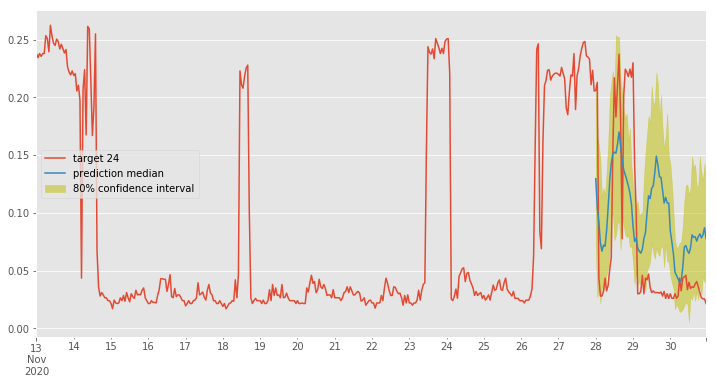

i: 25 sd029
RMSE: 0.10138900236955528
MAE: 0.08065727311666666
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00   0.078    0.000
2020-11-28 01:00:00   0.048    0.000
2020-11-28 02:00:00   0.008    0.000
2020-11-28 03:00:00   0.027    0.000
2020-11-28 04:00:00   0.067    0.000
...                     ...      ...
2020-11-30 19:00:00   0.114    0.000
2020-11-30 20:00:00   0.125    0.000
2020-11-30 21:00:00   0.122    0.000
2020-11-30 22:00:00   0.168    0.000
2020-11-30 23:00:00   0.175    0.000

[72 rows x 2 columns]


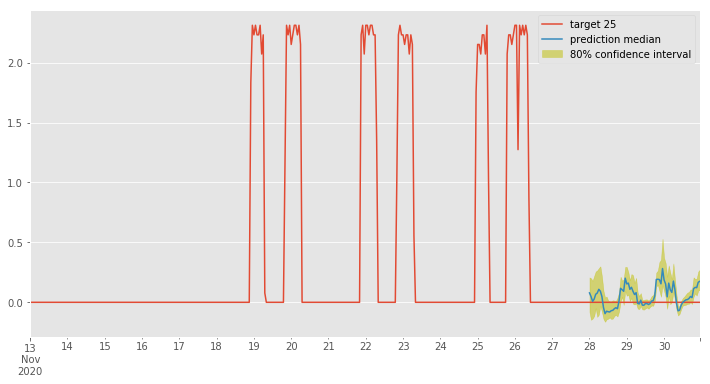

i: 26 sd031
RMSE: 0.590321750031761
MAE: 0.44099570314315933
Target Mean: 2.3367910385131836
sMAPE: 0.20289249095064998
                     y_pred  y_label
2020-11-28 00:00:00   2.358    2.448
2020-11-28 01:00:00   2.425    2.346
2020-11-28 02:00:00   2.352    2.499
2020-11-28 03:00:00   2.282    2.652
2020-11-28 04:00:00   2.271    2.550
...                     ...      ...
2020-11-30 19:00:00   2.612    2.907
2020-11-30 20:00:00   2.523    2.856
2020-11-30 21:00:00   2.435    2.856
2020-11-30 22:00:00   2.540    2.856
2020-11-30 23:00:00   2.486    2.652

[72 rows x 2 columns]


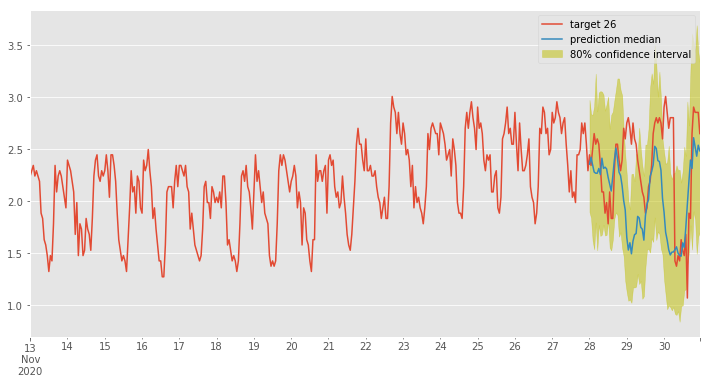

i: 27 sd032
RMSE: 2.200316275992483
MAE: 1.8910890321017075
Target Mean: 7.531833171844482
sMAPE: 0.2886289788984927
                     y_pred  y_label
2020-11-28 00:00:00   7.590    6.336
2020-11-28 01:00:00   7.685    6.896
2020-11-28 02:00:00   7.362    7.596
2020-11-28 03:00:00   7.482    8.716
2020-11-28 04:00:00   7.025    8.716
...                     ...      ...
2020-11-30 19:00:00   7.244    9.136
2020-11-30 20:00:00   7.488    9.136
2020-11-30 21:00:00   7.246    8.296
2020-11-30 22:00:00   7.266    7.456
2020-11-30 23:00:00   7.250    6.756

[72 rows x 2 columns]


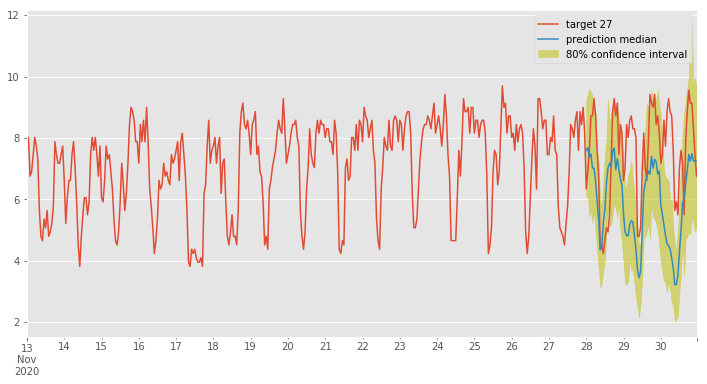

i: 28 sd033
RMSE: 0.32683982290233754
MAE: 0.26442205906266003
Target Mean: 0.9328473210334778
sMAPE: 0.26728734819286604
                     y_pred  y_label
2020-11-28 00:00:00   1.120    0.864
2020-11-28 01:00:00   1.080    0.931
2020-11-28 02:00:00   1.257    1.130
2020-11-28 03:00:00   1.447    1.396
2020-11-28 04:00:00   1.403    1.130
...                     ...      ...
2020-11-30 19:00:00   1.278    1.929
2020-11-30 20:00:00   1.228    1.530
2020-11-30 21:00:00   1.263    1.530
2020-11-30 22:00:00   1.298    1.396
2020-11-30 23:00:00   1.077    1.064

[72 rows x 2 columns]


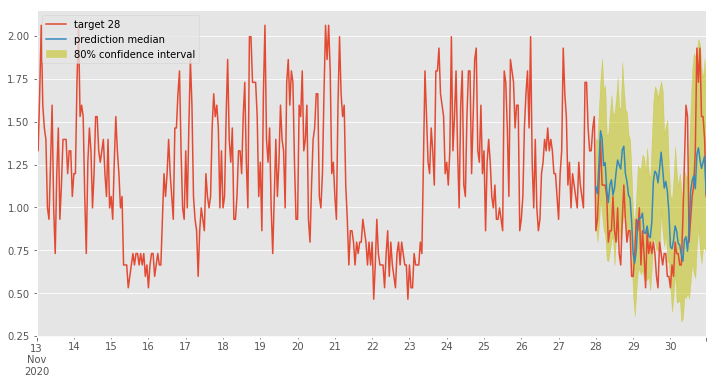

i: 29 sd034
RMSE: 0.26132802214220313
MAE: 0.21748882697061123
Target Mean: 0.9040490388870239
sMAPE: 0.25410386822662534
                     y_pred  y_label
2020-11-28 00:00:00   1.087    0.998
2020-11-28 01:00:00   1.192    1.495
2020-11-28 02:00:00   1.072    0.998
2020-11-28 03:00:00   0.972    0.998
2020-11-28 04:00:00   0.963    1.247
...                     ...      ...
2020-11-30 19:00:00   1.022    1.247
2020-11-30 20:00:00   1.001    0.998
2020-11-30 21:00:00   0.994    0.748
2020-11-30 22:00:00   1.032    0.998
2020-11-30 23:00:00   1.019    1.247

[72 rows x 2 columns]


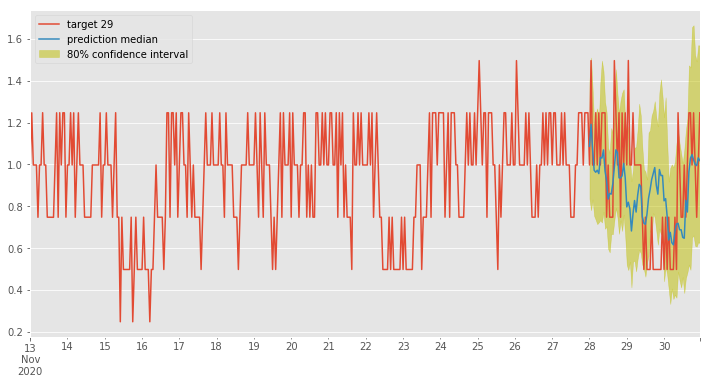

i: 30 sd036
RMSE: 0.2290511868622426
MAE: 0.18380732585897305
Target Mean: 0.5953333377838135
sMAPE: 0.3133496458023818
                     y_pred  y_label
2020-11-28 00:00:00   0.635    0.684
2020-11-28 01:00:00   0.691    1.064
2020-11-28 02:00:00   0.736    0.589
2020-11-28 03:00:00   0.700    0.855
2020-11-28 04:00:00   0.709    0.646
...                     ...      ...
2020-11-30 19:00:00   0.711    0.380
2020-11-30 20:00:00   0.714    0.323
2020-11-30 21:00:00   0.740    0.380
2020-11-30 22:00:00   0.668    0.323
2020-11-30 23:00:00   0.694    0.380

[72 rows x 2 columns]


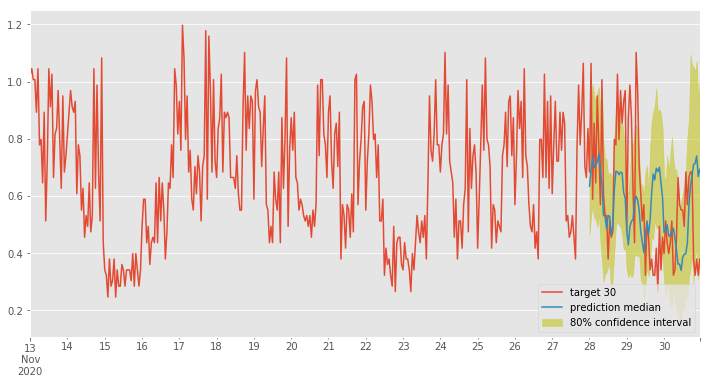

i: 31 sd037
RMSE: 0.1042688403078875
MAE: 0.08528807822064202
Target Mean: 0.4666387736797333
sMAPE: 0.20291222408702775
                     y_pred  y_label
2020-11-28 00:00:00   0.380    0.451
2020-11-28 01:00:00   0.405    0.517
2020-11-28 02:00:00   0.433    0.417
2020-11-28 03:00:00   0.417    0.417
2020-11-28 04:00:00   0.419    0.434
...                     ...      ...
2020-11-30 19:00:00   0.520    0.502
2020-11-30 20:00:00   0.497    0.436
2020-11-30 21:00:00   0.502    0.436
2020-11-30 22:00:00   0.466    0.419
2020-11-30 23:00:00   0.441    0.386

[72 rows x 2 columns]


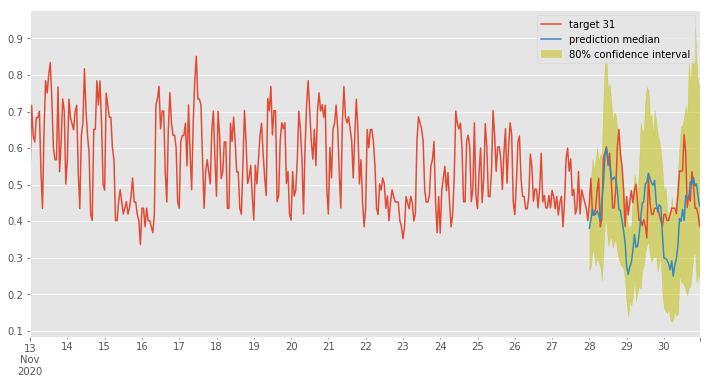

i: 32 sd038
RMSE: 0.30878539947603606
MAE: 0.23760102606239386
Target Mean: 0.9774032235145569
sMAPE: 0.24702256553147336
                     y_pred  y_label
2020-11-28 00:00:00   0.919    1.019
2020-11-28 01:00:00   0.814    0.883
2020-11-28 02:00:00   0.987    1.359
2020-11-28 03:00:00   1.173    1.834
2020-11-28 04:00:00   1.050    1.494
...                     ...      ...
2020-11-30 19:00:00   1.129    0.883
2020-11-30 20:00:00   1.027    0.815
2020-11-30 21:00:00   1.014    0.815
2020-11-30 22:00:00   1.033    0.747
2020-11-30 23:00:00   0.949    0.815

[72 rows x 2 columns]


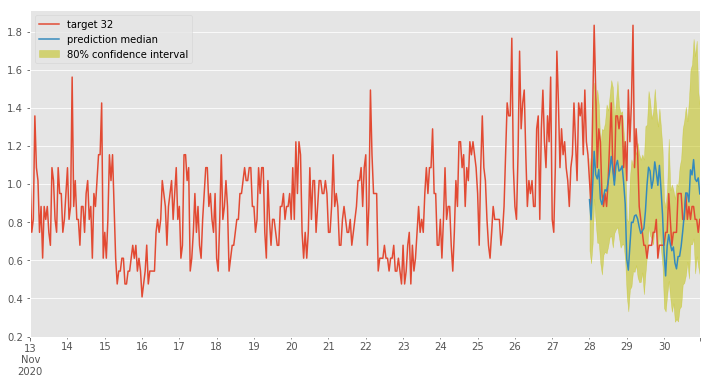

i: 33 sd039
RMSE: 0.26476497375424884
MAE: 0.21074475927062922
Target Mean: 1.0885279178619385
sMAPE: 0.20629538674194198
                     y_pred  y_label
2020-11-28 00:00:00   1.128    1.115
2020-11-28 01:00:00   1.089    1.319
2020-11-28 02:00:00   1.075    1.319
2020-11-28 03:00:00   1.119    1.218
2020-11-28 04:00:00   1.147    1.217
...                     ...      ...
2020-11-30 19:00:00   1.156    1.317
2020-11-30 20:00:00   1.165    1.316
2020-11-30 21:00:00   1.180    1.265
2020-11-30 22:00:00   1.074    1.267
2020-11-30 23:00:00   1.069    1.064

[72 rows x 2 columns]


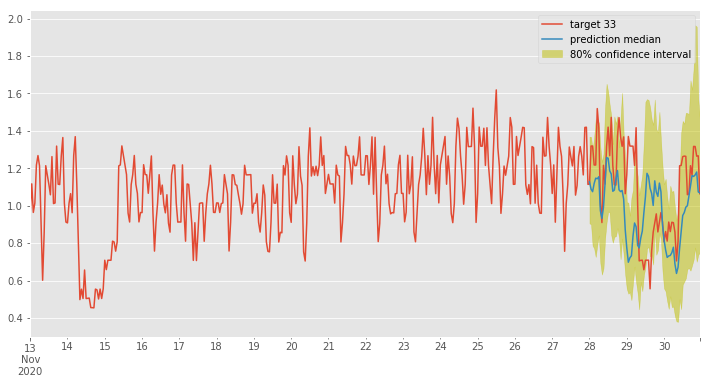

i: 34 sd040
RMSE: 0.3085882070777795
MAE: 0.25681108650721385
Target Mean: 1.1179234981536865
sMAPE: 0.21932504036057882
                     y_pred  y_label
2020-11-28 00:00:00   1.228    1.645
2020-11-28 01:00:00   1.282    1.346
2020-11-28 02:00:00   1.417    1.446
2020-11-28 03:00:00   1.468    1.246
2020-11-28 04:00:00   1.464    1.246
...                     ...      ...
2020-11-30 19:00:00   1.454    0.948
2020-11-30 20:00:00   1.464    1.048
2020-11-30 21:00:00   1.480    1.296
2020-11-30 22:00:00   1.394    0.998
2020-11-30 23:00:00   1.352    1.048

[72 rows x 2 columns]


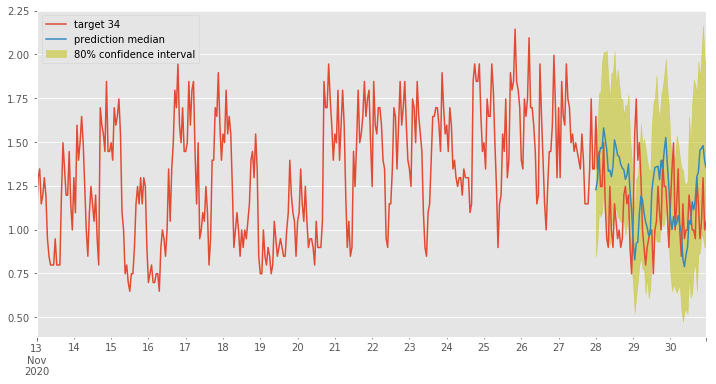

i: 35 sd042
RMSE: 0.3836787252063628
MAE: 0.308467354208771
Target Mean: 1.2395063638687134
sMAPE: 0.26177522431718536
                     y_pred  y_label
2020-11-28 00:00:00   1.176    1.210
2020-11-28 01:00:00   1.191    1.110
2020-11-28 02:00:00   1.132    1.513
2020-11-28 03:00:00   1.136    1.512
2020-11-28 04:00:00   1.141    1.512
...                     ...      ...
2020-11-30 19:00:00   1.458    1.513
2020-11-30 20:00:00   1.401    1.714
2020-11-30 21:00:00   1.417    1.613
2020-11-30 22:00:00   1.496    1.512
2020-11-30 23:00:00   1.405    1.008

[72 rows x 2 columns]


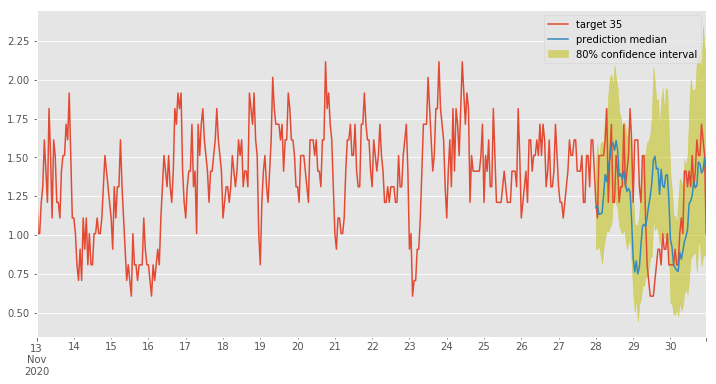

i: 36 sd043
RMSE: 0.18596294067583719
MAE: 0.14572399109902712
Target Mean: 0.7300417423248291
sMAPE: 0.20354001899193325
                     y_pred  y_label
2020-11-28 00:00:00   0.718    1.046
2020-11-28 01:00:00   0.816    1.247
2020-11-28 02:00:00   0.740    1.046
2020-11-28 03:00:00   0.711    0.647
2020-11-28 04:00:00   0.754    0.747
...                     ...      ...
2020-11-30 19:00:00   0.690    0.747
2020-11-30 20:00:00   0.702    0.797
2020-11-30 21:00:00   0.704    0.548
2020-11-30 22:00:00   0.662    0.697
2020-11-30 23:00:00   0.707    0.697

[72 rows x 2 columns]


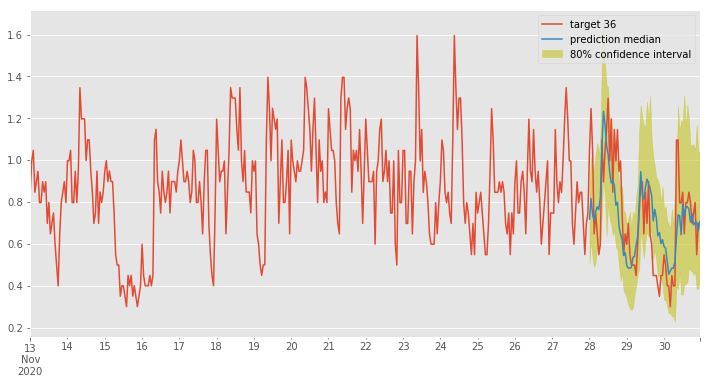

i: 37 sd045
RMSE: 0.01099514691030216
MAE: 0.008556217716275275
Target Mean: 0.016055556014180183
sMAPE: 0.6926328147102904
                     y_pred  y_label
2020-11-28 00:00:00   0.008    0.014
2020-11-28 01:00:00   0.012    0.004
2020-11-28 02:00:00   0.009    0.014
2020-11-28 03:00:00   0.013    0.004
2020-11-28 04:00:00   0.008    0.014
...                     ...      ...
2020-11-30 19:00:00   0.001    0.004
2020-11-30 20:00:00   0.004    0.014
2020-11-30 21:00:00   0.004    0.004
2020-11-30 22:00:00   0.006    0.004
2020-11-30 23:00:00   0.005    0.014

[72 rows x 2 columns]


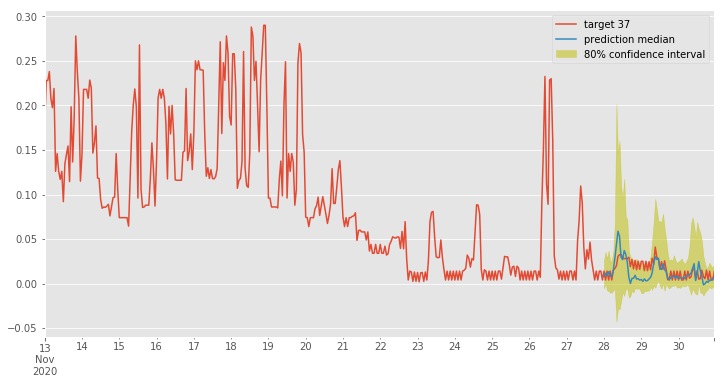

i: 38 sd046
RMSE: 0.8234903519912804
MAE: 0.7253664315964112
Target Mean: 1.2376805543899536
sMAPE: 0.7182839374232546
                     y_pred  y_label
2020-11-28 00:00:00   1.956    2.612
2020-11-28 01:00:00   1.952    2.492
2020-11-28 02:00:00   1.744    2.552
2020-11-28 03:00:00   1.453    2.552
2020-11-28 04:00:00   1.445    2.552
...                     ...      ...
2020-11-30 19:00:00   0.877    2.252
2020-11-30 20:00:00   1.034    1.592
2020-11-30 21:00:00   1.272    1.412
2020-11-30 22:00:00   1.188    1.172
2020-11-30 23:00:00   1.383    1.352

[72 rows x 2 columns]


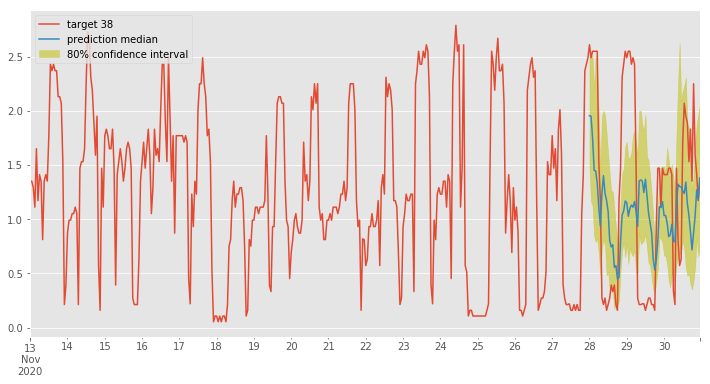

i: 39 sd047
RMSE: 0.0896159623522604
MAE: 0.056799169560717386
Target Mean: 0.08111110329627991
sMAPE: 0.7927793909623386
                     y_pred  y_label
2020-11-28 00:00:00   0.007    0.012
2020-11-28 01:00:00   0.007    0.006
2020-11-28 02:00:00   0.008    0.012
2020-11-28 03:00:00   0.005    0.006
2020-11-28 04:00:00   0.007    0.012
...                     ...      ...
2020-11-30 19:00:00   0.029    0.023
2020-11-30 20:00:00  -0.012    0.023
2020-11-30 21:00:00  -0.006    0.028
2020-11-30 22:00:00   0.001    0.028
2020-11-30 23:00:00   0.004    0.023

[72 rows x 2 columns]


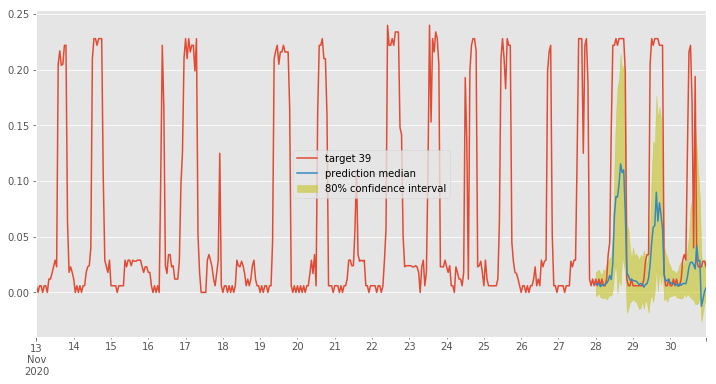

i: 40 sd048
RMSE: 0.030024370313743238
MAE: 0.024180359517175995
Target Mean: 0.1371111422777176
sMAPE: 0.19718978537282494
                     y_pred  y_label
2020-11-28 00:00:00   0.125    0.136
2020-11-28 01:00:00   0.126    0.116
2020-11-28 02:00:00   0.119    0.136
2020-11-28 03:00:00   0.127    0.136
2020-11-28 04:00:00   0.133    0.136
...                     ...      ...
2020-11-30 19:00:00   0.118    0.156
2020-11-30 20:00:00   0.128    0.136
2020-11-30 21:00:00   0.122    0.136
2020-11-30 22:00:00   0.118    0.156
2020-11-30 23:00:00   0.125    0.116

[72 rows x 2 columns]


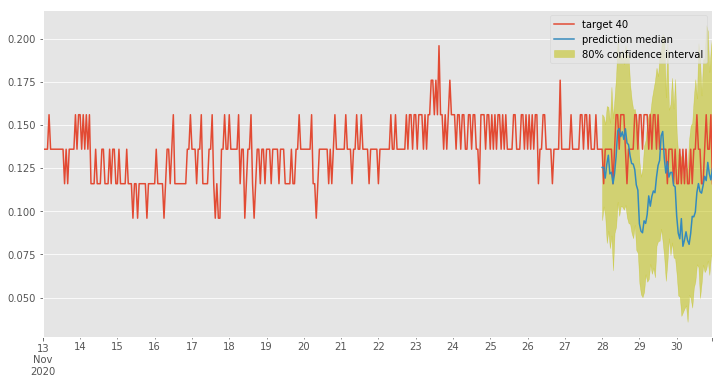

i: 41 sd049
RMSE: 0.1377189480225013
MAE: 0.11228518684565003
Target Mean: 0.43086108565330505
sMAPE: 0.2880445820869719
                     y_pred  y_label
2020-11-28 00:00:00   0.347    0.294
2020-11-28 01:00:00   0.341    0.323
2020-11-28 02:00:00   0.353    0.323
2020-11-28 03:00:00   0.336    0.352
2020-11-28 04:00:00   0.353    0.352
...                     ...      ...
2020-11-30 19:00:00   0.399    0.500
2020-11-30 20:00:00   0.269    0.352
2020-11-30 21:00:00   0.289    0.382
2020-11-30 22:00:00   0.250    0.352
2020-11-30 23:00:00   0.298    0.354

[72 rows x 2 columns]


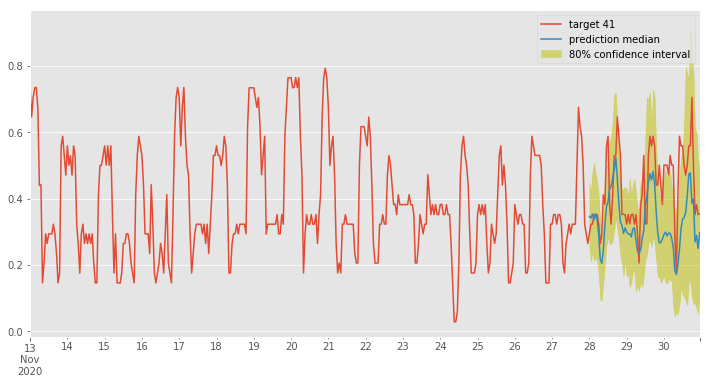

i: 42 sd050
RMSE: 0.3165355820702659
MAE: 0.24880582342566632
Target Mean: 1.3220000267028809
sMAPE: 0.21572567772085555
                     y_pred  y_label
2020-11-28 00:00:00   1.103    1.222
2020-11-28 01:00:00   1.115    1.252
2020-11-28 02:00:00   1.100    1.282
2020-11-28 03:00:00   1.095    1.282
2020-11-28 04:00:00   1.090    1.312
...                     ...      ...
2020-11-30 19:00:00   1.052    1.132
2020-11-30 20:00:00   1.049    1.072
2020-11-30 21:00:00   1.072    1.132
2020-11-30 22:00:00   1.117    1.102
2020-11-30 23:00:00   1.135    1.102

[72 rows x 2 columns]


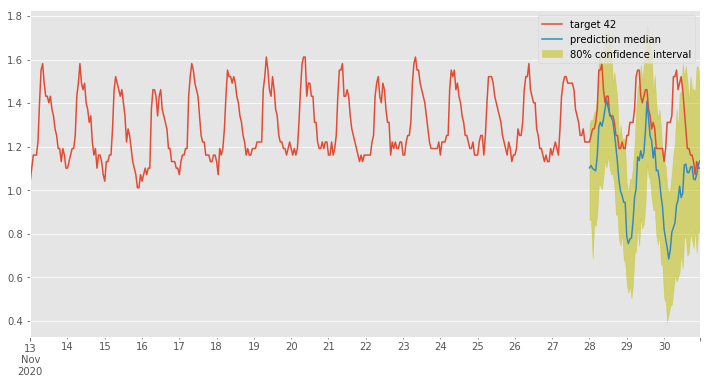

i: 43 sd051
RMSE: 0.15404496399632076
MAE: 0.12765613818761917
Target Mean: 0.571326494216919
sMAPE: 0.2614822084593162
                     y_pred  y_label
2020-11-28 00:00:00   0.453    0.524
2020-11-28 01:00:00   0.438    0.524
2020-11-28 02:00:00   0.448    0.539
2020-11-28 03:00:00   0.448    0.567
2020-11-28 04:00:00   0.483    0.596
...                     ...      ...
2020-11-30 19:00:00   0.448    0.553
2020-11-30 20:00:00   0.436    0.524
2020-11-30 21:00:00   0.457    0.539
2020-11-30 22:00:00   0.453    0.539
2020-11-30 23:00:00   0.446    0.524

[72 rows x 2 columns]


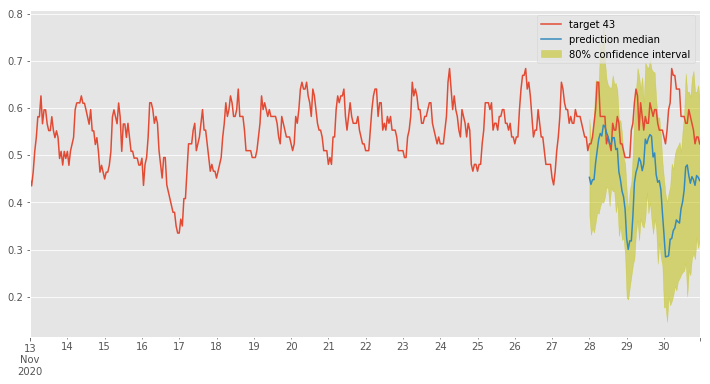

i: 44 sd053
RMSE: 0.2907377385135647
MAE: 0.23307546269553614
Target Mean: 1.0353333950042725
sMAPE: 0.25772694970547133
                     y_pred  y_label
2020-11-28 00:00:00   0.710    0.732
2020-11-28 01:00:00   0.706    0.752
2020-11-28 02:00:00   0.734    0.772
2020-11-28 03:00:00   0.767    0.832
2020-11-28 04:00:00   0.873    0.932
...                     ...      ...
2020-11-30 19:00:00   0.834    0.872
2020-11-30 20:00:00   0.825    0.952
2020-11-30 21:00:00   0.768    0.892
2020-11-30 22:00:00   0.770    0.872
2020-11-30 23:00:00   0.758    0.872

[72 rows x 2 columns]


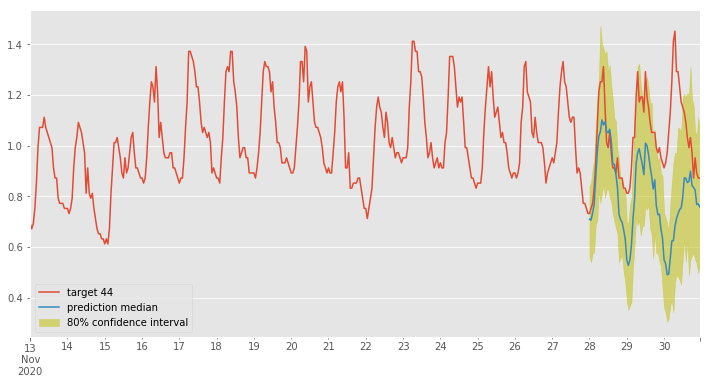

i: 45 sd055
RMSE: 0.0737363402878217
MAE: 0.06421240584527647
Target Mean: 0.3350277841091156
sMAPE: 0.19171023910450002
                     y_pred  y_label
2020-11-28 00:00:00   0.275    0.236
2020-11-28 01:00:00   0.282    0.256
2020-11-28 02:00:00   0.311    0.276
2020-11-28 03:00:00   0.321    0.266
2020-11-28 04:00:00   0.365    0.276
...                     ...      ...
2020-11-30 19:00:00   0.379    0.276
2020-11-30 20:00:00   0.366    0.276
2020-11-30 21:00:00   0.334    0.256
2020-11-30 22:00:00   0.333    0.266
2020-11-30 23:00:00   0.333    0.256

[72 rows x 2 columns]


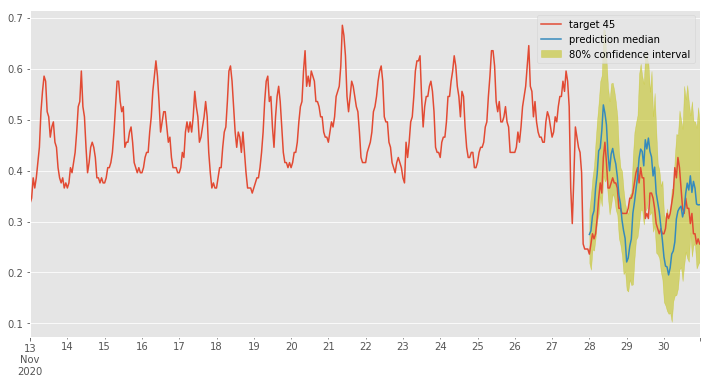

i: 46 sd056
RMSE: 0.12161672904850673
MAE: 0.09956523092880948
Target Mean: 0.5361250042915344
sMAPE: 0.21859062791037925
                     y_pred  y_label
2020-11-28 00:00:00   0.430    0.464
2020-11-28 01:00:00   0.404    0.406
2020-11-28 02:00:00   0.415    0.484
2020-11-28 03:00:00   0.419    0.464
2020-11-28 04:00:00   0.440    0.504
...                     ...      ...
2020-11-30 19:00:00   0.477    0.524
2020-11-30 20:00:00   0.458    0.524
2020-11-30 21:00:00   0.458    0.504
2020-11-30 22:00:00   0.436    0.464
2020-11-30 23:00:00   0.450    0.464

[72 rows x 2 columns]


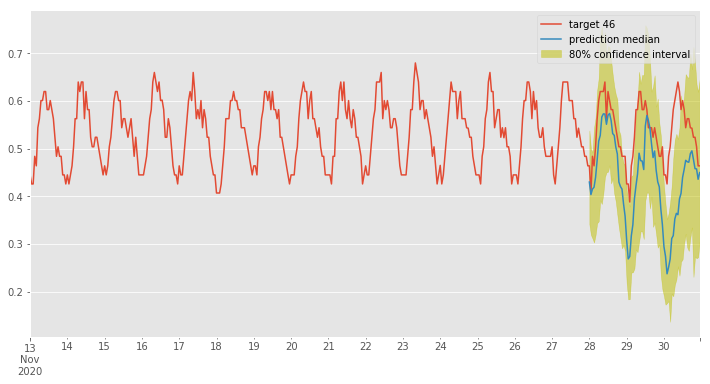

i: 47 sd057
RMSE: 0.15331103663027326
MAE: 0.10102198087184439
Target Mean: 0.24166668951511383
sMAPE: 0.5449373693957705
                     y_pred  y_label
2020-11-28 00:00:00   0.024    0.015
2020-11-28 01:00:00   0.028    0.015
2020-11-28 02:00:00   0.031    0.015
2020-11-28 03:00:00   0.030    0.000
2020-11-28 04:00:00   0.037    0.015
...                     ...      ...
2020-11-30 19:00:00   0.026    0.045
2020-11-30 20:00:00   0.030    0.045
2020-11-30 21:00:00   0.032    0.030
2020-11-30 22:00:00   0.031    0.045
2020-11-30 23:00:00   0.043    0.015

[72 rows x 2 columns]


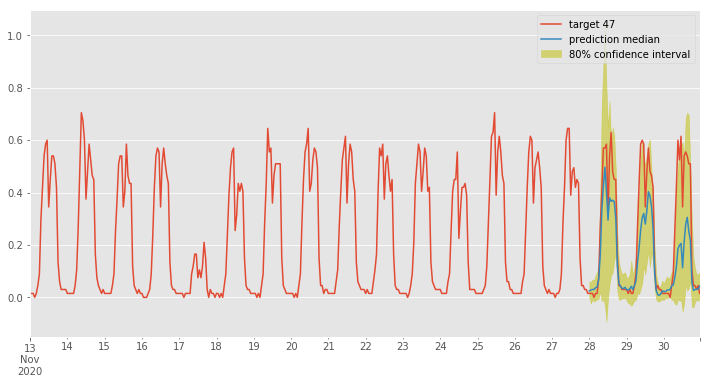

i: 48 sd058
RMSE: 0.13688121792284907
MAE: 0.1051757993812337
Target Mean: 0.5304304957389832
sMAPE: 0.22841148161343847
                     y_pred  y_label
2020-11-28 00:00:00   0.385    0.369
2020-11-28 01:00:00   0.374    0.407
2020-11-28 02:00:00   0.369    0.388
2020-11-28 03:00:00   0.381    0.407
2020-11-28 04:00:00   0.344    0.388
...                     ...      ...
2020-11-30 19:00:00   0.460    0.484
2020-11-30 20:00:00   0.417    0.445
2020-11-30 21:00:00   0.391    0.445
2020-11-30 22:00:00   0.420    0.465
2020-11-30 23:00:00   0.389    0.484

[72 rows x 2 columns]


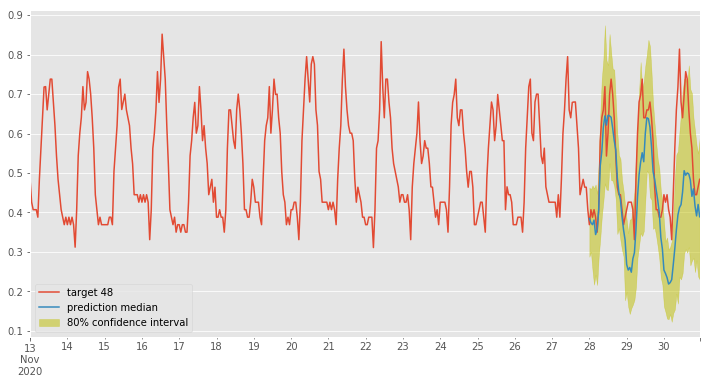

i: 49 sd059
RMSE: 0.24568607664209294
MAE: 0.1910773068704667
Target Mean: 0.9928335547447205
sMAPE: 0.22322861107246442
                     y_pred  y_label
2020-11-28 00:00:00   0.696    0.787
2020-11-28 01:00:00   0.686    0.787
2020-11-28 02:00:00   0.761    0.862
2020-11-28 03:00:00   0.821    1.012
2020-11-28 04:00:00   0.871    1.042
...                     ...      ...
2020-11-30 19:00:00   0.864    0.982
2020-11-30 20:00:00   0.856    0.907
2020-11-30 21:00:00   0.789    0.847
2020-11-30 22:00:00   0.793    0.787
2020-11-30 23:00:00   0.769    0.727

[72 rows x 2 columns]


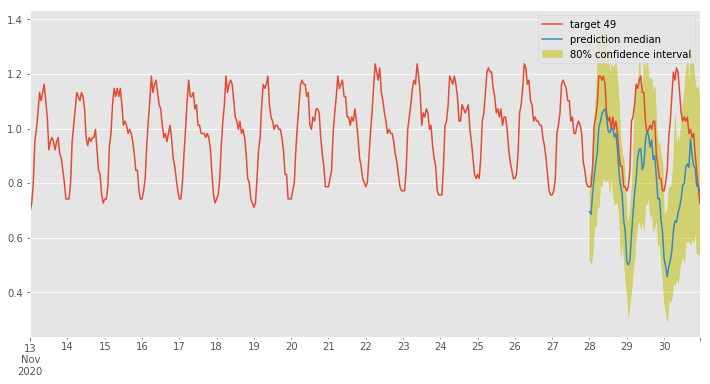

i: 50 sd060
RMSE: 0.02763073001595201
MAE: 0.02313650285506789
Target Mean: 0.14191663265228271
sMAPE: 0.17491317005875193
                     y_pred  y_label
2020-11-28 00:00:00   0.145    0.144
2020-11-28 01:00:00   0.145    0.144
2020-11-28 02:00:00   0.139    0.144
2020-11-28 03:00:00   0.139    0.164
2020-11-28 04:00:00   0.148    0.154
...                     ...      ...
2020-11-30 19:00:00   0.163    0.134
2020-11-30 20:00:00   0.155    0.114
2020-11-30 21:00:00   0.153    0.144
2020-11-30 22:00:00   0.155    0.134
2020-11-30 23:00:00   0.153    0.134

[72 rows x 2 columns]


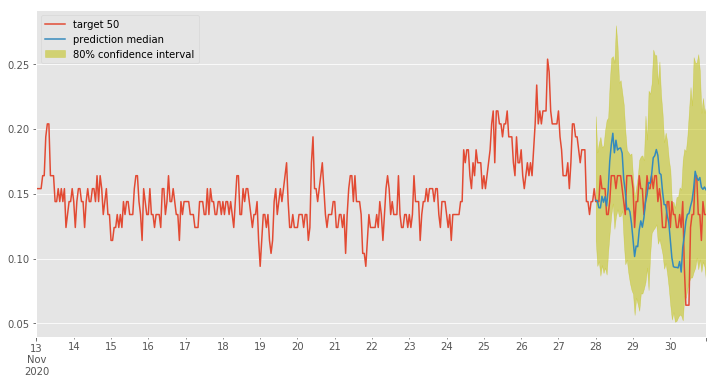

i: 51 sd061
RMSE: 0.15801940202425271
MAE: 0.11551344324310676
Target Mean: 0.40583330392837524
sMAPE: 0.4048213716742729
                     y_pred  y_label
2020-11-28 00:00:00   0.005    0.045
2020-11-28 01:00:00   0.004    0.030
2020-11-28 02:00:00   0.021    0.045
2020-11-28 03:00:00   0.039    0.030
2020-11-28 04:00:00   0.042    0.030
...                     ...      ...
2020-11-30 19:00:00   0.525    0.675
2020-11-30 20:00:00   0.486    0.660
2020-11-30 21:00:00   0.312    0.435
2020-11-30 22:00:00   0.151    0.060
2020-11-30 23:00:00   0.077    0.060

[72 rows x 2 columns]


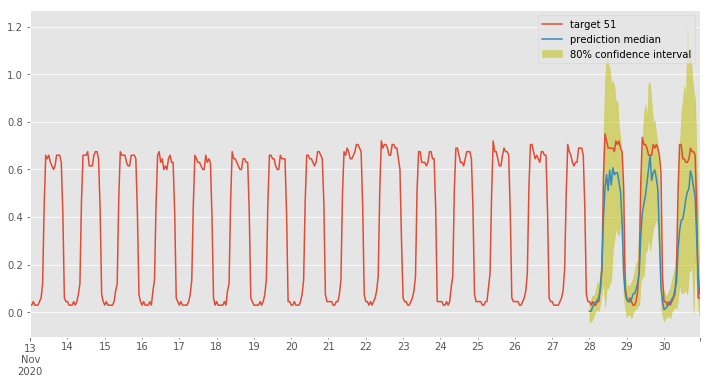

i: 52 sd062
RMSE: 0.5135550806350241
MAE: 0.31060648144635017
Target Mean: 0.4404168426990509
sMAPE: 1.1369896188406388
                     y_pred  y_label
2020-11-28 00:00:00   0.832    1.620
2020-11-28 01:00:00   0.686    1.590
2020-11-28 02:00:00   0.683    1.620
2020-11-28 03:00:00   0.313    0.960
2020-11-28 04:00:00   0.076    0.300
...                     ...      ...
2020-11-30 19:00:00   0.015    0.030
2020-11-30 20:00:00   0.019    0.030
2020-11-30 21:00:00   0.035    0.000
2020-11-30 22:00:00   0.031    0.030
2020-11-30 23:00:00   0.283    1.530

[72 rows x 2 columns]


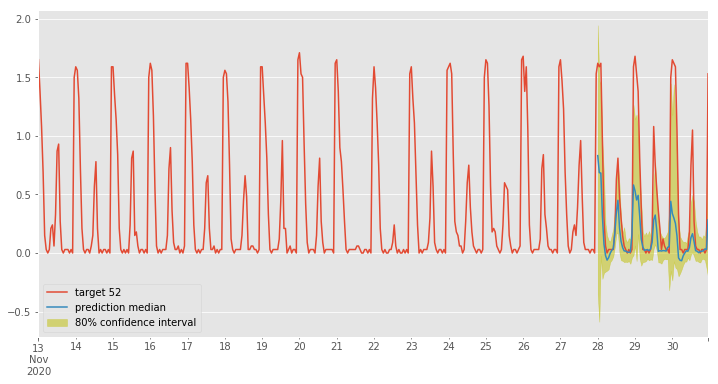

i: 53 sd064
RMSE: 0.006993707442410772
MAE: 0.005961398769577197
Target Mean: 0.009374994784593582
sMAPE: 0.9272398748299794
                     y_pred  y_label
2020-11-28 00:00:00   0.006    0.007
2020-11-28 01:00:00   0.006    0.000
2020-11-28 02:00:00   0.006    0.007
2020-11-28 03:00:00   0.008    0.000
2020-11-28 04:00:00   0.007    0.007
...                     ...      ...
2020-11-30 19:00:00   0.002    0.007
2020-11-30 20:00:00   0.004    0.007
2020-11-30 21:00:00   0.003    0.015
2020-11-30 22:00:00   0.002    0.007
2020-11-30 23:00:00   0.002    0.015

[72 rows x 2 columns]


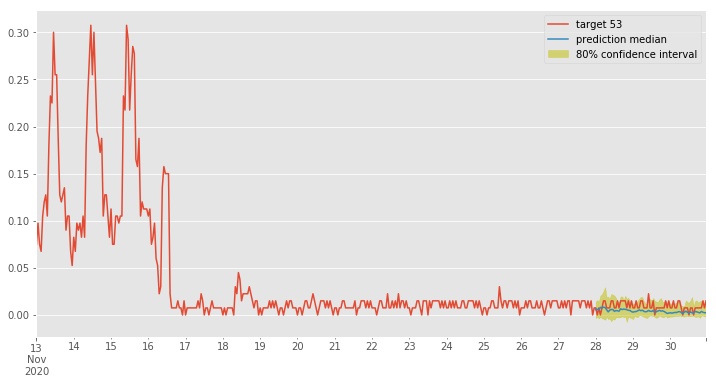

i: 54 sd065
RMSE: 0.030936747971849952
MAE: 0.02811306158888889
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.019    0.000
2020-11-28 01:00:00  -0.022    0.000
2020-11-28 02:00:00  -0.022    0.000
2020-11-28 03:00:00  -0.029    0.000
2020-11-28 04:00:00  -0.027    0.000
...                     ...      ...
2020-11-30 19:00:00  -0.010    0.000
2020-11-30 20:00:00  -0.014    0.000
2020-11-30 21:00:00  -0.016    0.000
2020-11-30 22:00:00  -0.011    0.000
2020-11-30 23:00:00  -0.010    0.000

[72 rows x 2 columns]


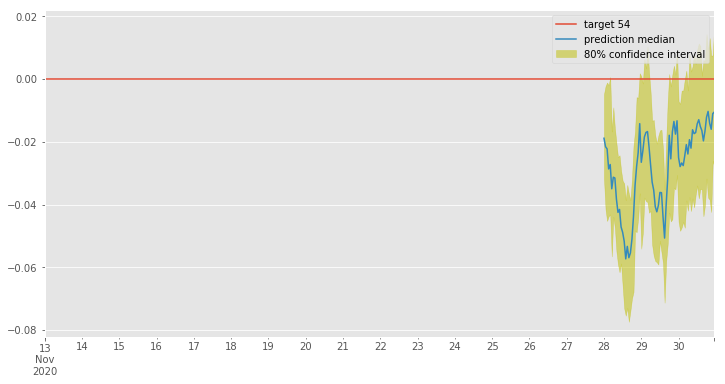

i: 55 sd066
RMSE: 0.8303272747080797
MAE: 0.7125812346765285
Target Mean: 2.3853750228881836
sMAPE: 0.3364305467578471
                     y_pred  y_label
2020-11-28 00:00:00   2.715    3.043
2020-11-28 01:00:00   2.730    3.399
2020-11-28 02:00:00   2.697    3.246
2020-11-28 03:00:00   2.564    3.246
2020-11-28 04:00:00   2.510    3.166
...                     ...      ...
2020-11-30 19:00:00   1.662    1.652
2020-11-30 20:00:00   1.768    1.730
2020-11-30 21:00:00   1.921    1.651
2020-11-30 22:00:00   2.240    3.438
2020-11-30 23:00:00   2.397    3.125

[72 rows x 2 columns]


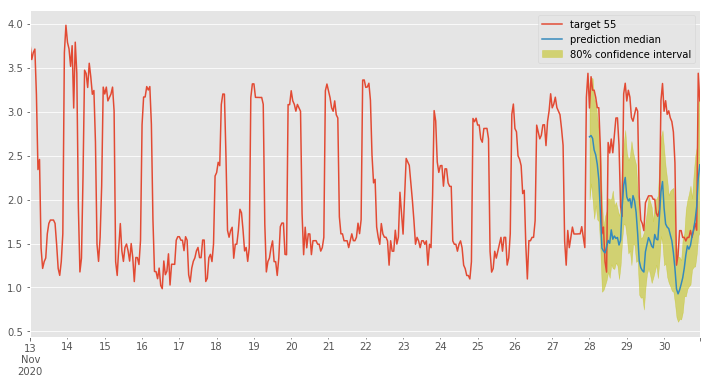

i: 56 sd067
RMSE: 0.10869199213928783
MAE: 0.07646720370285928
Target Mean: 0.23541668057441711
sMAPE: 0.32573831464168124
                     y_pred  y_label
2020-11-28 00:00:00   0.116    0.131
2020-11-28 01:00:00   0.097    0.146
2020-11-28 02:00:00   0.092    0.146
2020-11-28 03:00:00   0.082    0.146
2020-11-28 04:00:00   0.076    0.116
...                     ...      ...
2020-11-30 19:00:00   0.199    0.088
2020-11-30 20:00:00   0.167    0.074
2020-11-30 21:00:00   0.153    0.088
2020-11-30 22:00:00   0.142    0.074
2020-11-30 23:00:00   0.122    0.060

[72 rows x 2 columns]


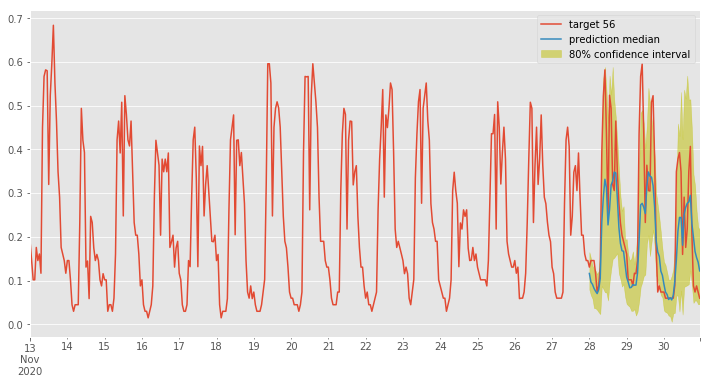

i: 57 sd068
RMSE: 0.06261191645866745
MAE: 0.030061361228482932
Target Mean: 0.05090278387069702
sMAPE: 0.6759506485332217
                     y_pred  y_label
2020-11-28 00:00:00   0.010    0.006
2020-11-28 01:00:00   0.010    0.006
2020-11-28 02:00:00   0.010    0.000
2020-11-28 03:00:00   0.009    0.006
2020-11-28 04:00:00   0.007    0.006
...                     ...      ...
2020-11-30 19:00:00  -0.007    0.012
2020-11-30 20:00:00  -0.002    0.012
2020-11-30 21:00:00   0.002    0.006
2020-11-30 22:00:00   0.002    0.000
2020-11-30 23:00:00   0.004    0.006

[72 rows x 2 columns]


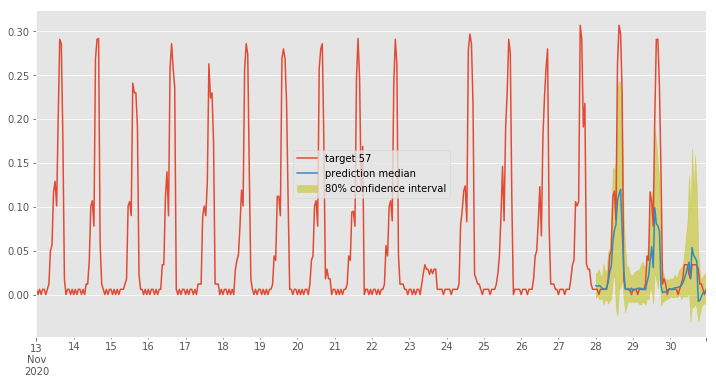

i: 58 sd069
RMSE: 0.021990715145889555
MAE: 0.014810856987357925
Target Mean: 0.01777777262032032
sMAPE: 1.671507342965193
                     y_pred  y_label
2020-11-28 00:00:00   0.005    0.020
2020-11-28 01:00:00   0.005    0.000
2020-11-28 02:00:00   0.001    0.000
2020-11-28 03:00:00   0.004    0.000
2020-11-28 04:00:00   0.007    0.020
...                     ...      ...
2020-11-30 19:00:00  -0.003    0.000
2020-11-30 20:00:00  -0.000    0.000
2020-11-30 21:00:00   0.002    0.020
2020-11-30 22:00:00   0.000    0.000
2020-11-30 23:00:00   0.001    0.000

[72 rows x 2 columns]


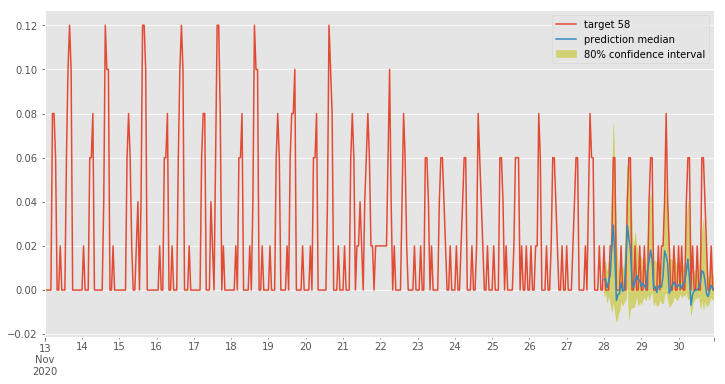

i: 59 sd070
RMSE: 0.1651855153067861
MAE: 0.12344849441274465
Target Mean: 0.2500694990158081
sMAPE: 0.6505778380848654
                     y_pred  y_label
2020-11-28 00:00:00   0.054    0.027
2020-11-28 01:00:00   0.065    0.027
2020-11-28 02:00:00   0.084    0.027
2020-11-28 03:00:00   0.079    0.027
2020-11-28 04:00:00   0.070    0.027
...                     ...      ...
2020-11-30 19:00:00   0.240    0.476
2020-11-30 20:00:00   0.084    0.416
2020-11-30 21:00:00   0.055    0.466
2020-11-30 22:00:00   0.054    0.496
2020-11-30 23:00:00   0.062    0.506

[72 rows x 2 columns]


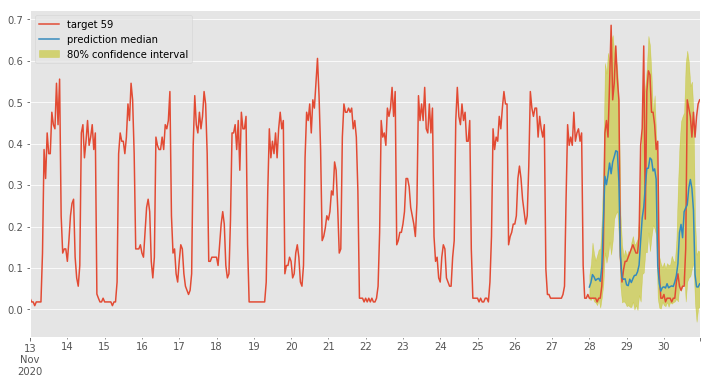

i: 60 sd071
RMSE: 0.06318487613767017
MAE: 0.055384754615504565
Target Mean: 0.20391666889190674
sMAPE: 0.313367203922328
                     y_pred  y_label
2020-11-28 00:00:00   0.155    0.180
2020-11-28 01:00:00   0.144    0.180
2020-11-28 02:00:00   0.136    0.168
2020-11-28 03:00:00   0.125    0.174
2020-11-28 04:00:00   0.127    0.168
...                     ...      ...
2020-11-30 19:00:00   0.187    0.264
2020-11-30 20:00:00   0.172    0.222
2020-11-30 21:00:00   0.167    0.198
2020-11-30 22:00:00   0.162    0.192
2020-11-30 23:00:00   0.154    0.192

[72 rows x 2 columns]


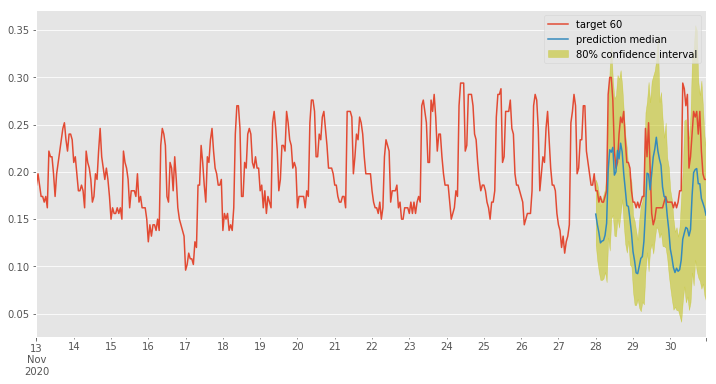

i: 61 sd072
RMSE: 0.01358583432518711
MAE: 0.010047266720187088
Target Mean: 0.0025277778040617704
sMAPE: 1.9118384343600698
                     y_pred  y_label
2020-11-28 00:00:00  -0.007    0.000
2020-11-28 01:00:00  -0.010    0.000
2020-11-28 02:00:00  -0.015    0.000
2020-11-28 03:00:00  -0.013    0.000
2020-11-28 04:00:00  -0.013    0.014
...                     ...      ...
2020-11-30 19:00:00  -0.014    0.000
2020-11-30 20:00:00  -0.009    0.000
2020-11-30 21:00:00  -0.006    0.000
2020-11-30 22:00:00  -0.004    0.000
2020-11-30 23:00:00  -0.003    0.014

[72 rows x 2 columns]


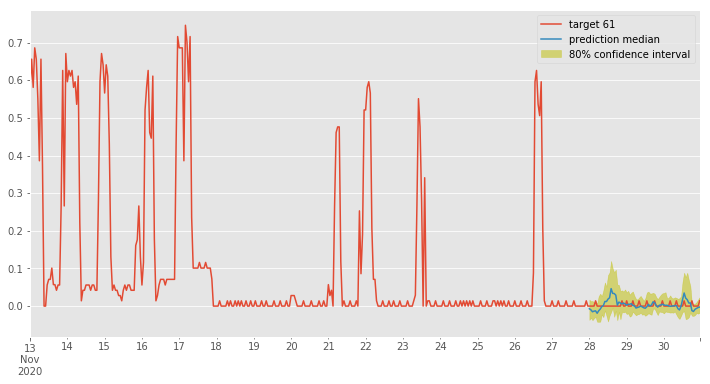

i: 62 sd073
RMSE: 0.0558716301873304
MAE: 0.04964144714435075
Target Mean: 0.04729166254401207
sMAPE: 1.6184696521748583
                     y_pred  y_label
2020-11-28 00:00:00   0.043    0.103
2020-11-28 01:00:00   0.015    0.000
2020-11-28 02:00:00   0.043    0.103
2020-11-28 03:00:00   0.020    0.000
2020-11-28 04:00:00   0.040    0.103
...                     ...      ...
2020-11-30 19:00:00   0.024    0.000
2020-11-30 20:00:00   0.023    0.103
2020-11-30 21:00:00   0.023    0.000
2020-11-30 22:00:00   0.023    0.103
2020-11-30 23:00:00   0.019    0.000

[72 rows x 2 columns]


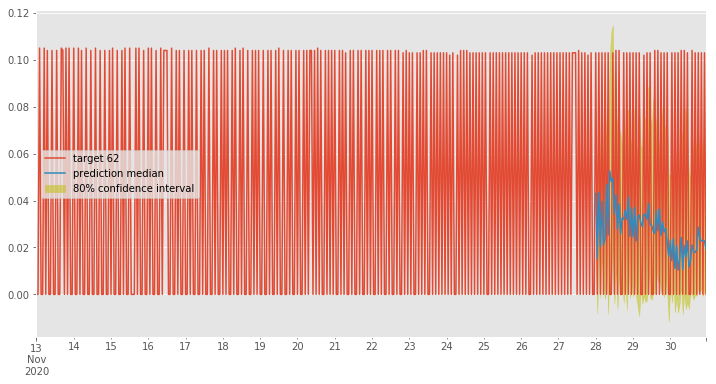

i: 63 sd074
RMSE: 0.2023574683590889
MAE: 0.1703867448766804
Target Mean: 0.9754793643951416
sMAPE: 0.17126486134940774
                     y_pred  y_label
2020-11-28 00:00:00   1.201    1.264
2020-11-28 01:00:00   1.155    1.304
2020-11-28 02:00:00   1.150    1.265
2020-11-28 03:00:00   1.116    1.224
2020-11-28 04:00:00   1.081    1.144
...                     ...      ...
2020-11-30 19:00:00   1.275    1.010
2020-11-30 20:00:00   1.247    1.096
2020-11-30 21:00:00   1.141    1.219
2020-11-30 22:00:00   1.236    1.302
2020-11-30 23:00:00   1.185    1.265

[72 rows x 2 columns]


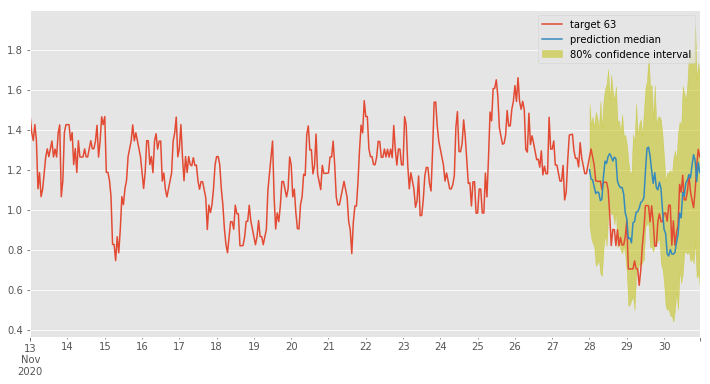

i: 64 sd075
RMSE: 0.360076619095492
MAE: 0.3050902858357624
Target Mean: 1.0264997482299805
sMAPE: 0.3200433507159947
                     y_pred  y_label
2020-11-28 00:00:00   1.013    1.242
2020-11-28 01:00:00   1.023    1.192
2020-11-28 02:00:00   1.052    1.192
2020-11-28 03:00:00   1.037    1.142
2020-11-28 04:00:00   1.008    1.092
...                     ...      ...
2020-11-30 19:00:00   1.504    1.242
2020-11-30 20:00:00   1.489    1.292
2020-11-30 21:00:00   1.530    0.892
2020-11-30 22:00:00   1.259    0.692
2020-11-30 23:00:00   1.235    0.792

[72 rows x 2 columns]


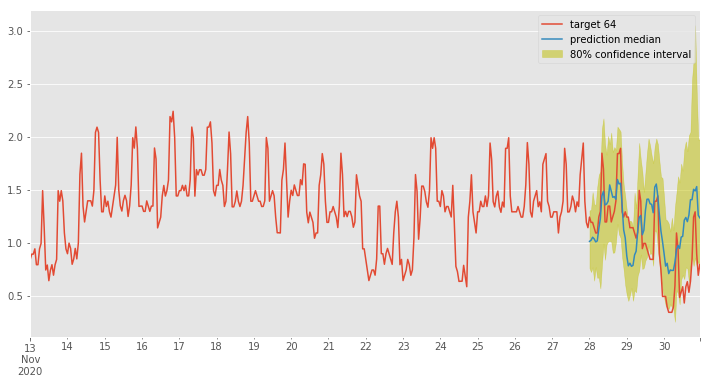

i: 65 sd076
RMSE: 4.453529566102565
MAE: 3.3980139758844405
Target Mean: 9.939165115356445
sMAPE: 0.36739524208305363
                     y_pred  y_label
2020-11-28 00:00:00  11.073    9.892
2020-11-28 01:00:00  10.624   13.190
2020-11-28 02:00:00   9.988   16.490
2020-11-28 03:00:00  11.121   16.493
2020-11-28 04:00:00  10.278   23.090
...                     ...      ...
2020-11-30 19:00:00  12.058   13.190
2020-11-30 20:00:00  11.862    9.892
2020-11-30 21:00:00  13.277   16.490
2020-11-30 22:00:00  13.506   13.193
2020-11-30 23:00:00  13.466   16.490

[72 rows x 2 columns]


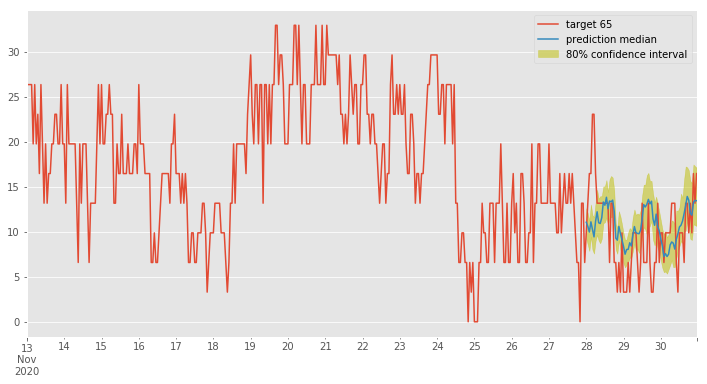

i: 66 sd077
RMSE: 0.09149934879403994
MAE: 0.0618358525023002
Target Mean: 0.11341672390699387
sMAPE: 0.91537544735121
                     y_pred  y_label
2020-11-28 00:00:00   0.475    0.596
2020-11-28 01:00:00   0.467    0.656
2020-11-28 02:00:00   0.385    0.476
2020-11-28 03:00:00   0.499    0.676
2020-11-28 04:00:00   0.384    0.596
...                     ...      ...
2020-11-30 19:00:00   0.027    0.019
2020-11-30 20:00:00   0.034    0.038
2020-11-30 21:00:00   0.047    0.038
2020-11-30 22:00:00   0.107    0.077
2020-11-30 23:00:00   0.138    0.316

[72 rows x 2 columns]


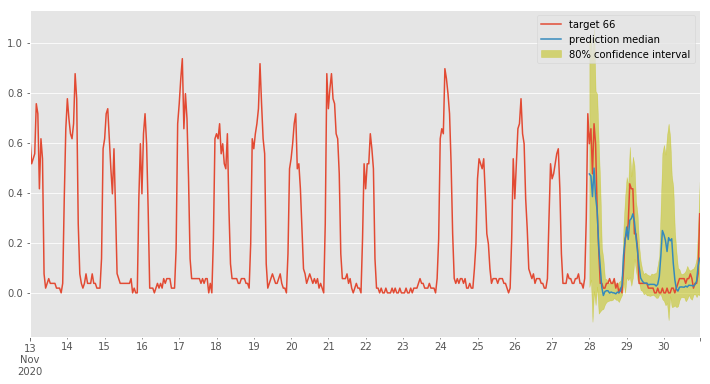

i: 67 sd078
RMSE: 0.40158628383631045
MAE: 0.3755232592500184
Target Mean: 0.9766111373901367
sMAPE: 0.5383590894560897
                     y_pred  y_label
2020-11-28 00:00:00   1.219    1.376
2020-11-28 01:00:00   1.218    1.346
2020-11-28 02:00:00   1.173    1.346
2020-11-28 03:00:00   1.174    1.346
2020-11-28 04:00:00   1.145    1.346
...                     ...      ...
2020-11-30 19:00:00   0.485    0.716
2020-11-30 20:00:00   0.703    1.346
2020-11-30 21:00:00   0.803    1.376
2020-11-30 22:00:00   0.846    1.316
2020-11-30 23:00:00   0.878    1.346

[72 rows x 2 columns]


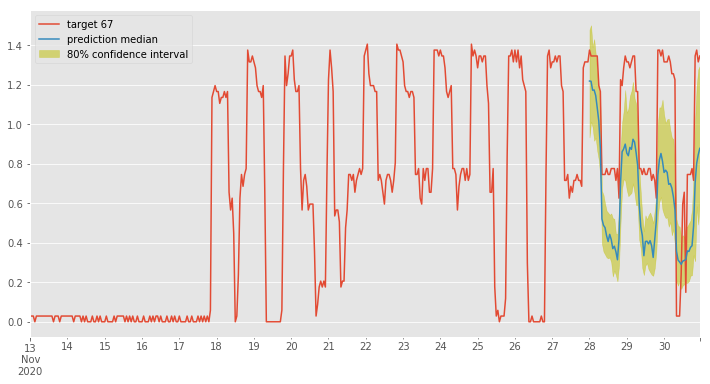

i: 68 sd079
RMSE: 0.039611886768128976
MAE: 0.02957181996826029
Target Mean: 0.09266668558120728
sMAPE: 0.32903842964337193
                     y_pred  y_label
2020-11-28 00:00:00   0.130    0.168
2020-11-28 01:00:00   0.118    0.172
2020-11-28 02:00:00   0.096    0.156
2020-11-28 03:00:00   0.075    0.152
2020-11-28 04:00:00   0.047    0.052
...                     ...      ...
2020-11-30 19:00:00   0.053    0.052
2020-11-30 20:00:00   0.053    0.040
2020-11-30 21:00:00   0.051    0.064
2020-11-30 22:00:00   0.062    0.076
2020-11-30 23:00:00   0.084    0.172

[72 rows x 2 columns]


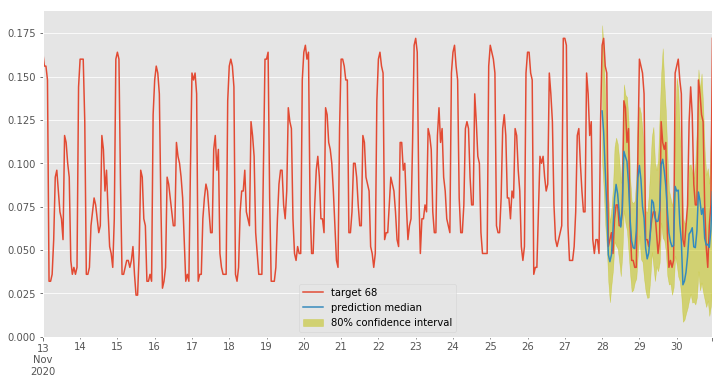

i: 69 sd080
RMSE: 0.0021085915711793433
MAE: 0.0015972830994259338
Target Mean: 0.0014027777360752225
sMAPE: 0.8696284697988951
                     y_pred  y_label
2020-11-28 00:00:00   0.005    0.002
2020-11-28 01:00:00   0.004    0.002
2020-11-28 02:00:00   0.004    0.002
2020-11-28 03:00:00   0.003    0.002
2020-11-28 04:00:00   0.005    0.002
...                     ...      ...
2020-11-30 19:00:00   0.001    0.000
2020-11-30 20:00:00   0.000    0.002
2020-11-30 21:00:00   0.001    0.002
2020-11-30 22:00:00   0.004    0.002
2020-11-30 23:00:00   0.003    0.002

[72 rows x 2 columns]


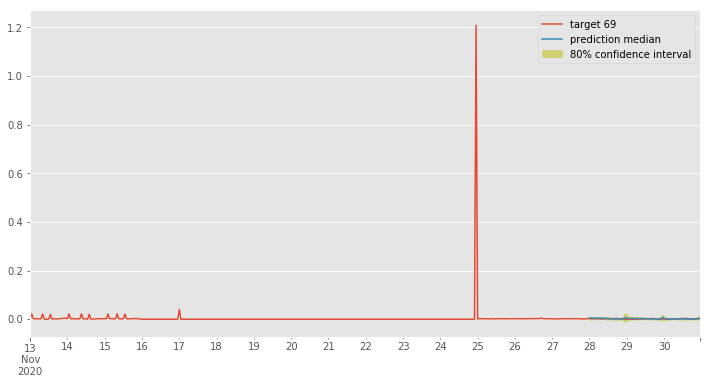

i: 70 sd081
RMSE: 0.11100857672255011
MAE: 0.08725583242763078
Target Mean: 0.4923332929611206
sMAPE: 0.20671954952515803
                     y_pred  y_label
2020-11-28 00:00:00   0.443    0.504
2020-11-28 01:00:00   0.425    0.480
2020-11-28 02:00:00   0.418    0.480
2020-11-28 03:00:00   0.382    0.432
2020-11-28 04:00:00   0.347    0.360
...                     ...      ...
2020-11-30 19:00:00   0.422    0.504
2020-11-30 20:00:00   0.442    0.456
2020-11-30 21:00:00   0.412    0.456
2020-11-30 22:00:00   0.405    0.480
2020-11-30 23:00:00   0.412    0.480

[72 rows x 2 columns]


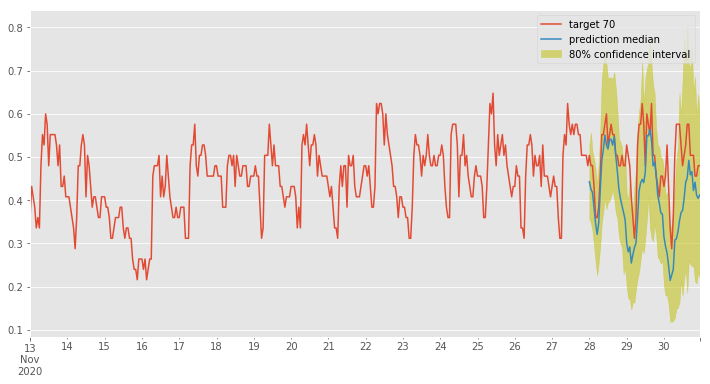

i: 71 sd082
RMSE: 0.05228597019548722
MAE: 0.04138600440502738
Target Mean: 0.09262964129447937
sMAPE: 0.5255800724826983
                     y_pred  y_label
2020-11-28 00:00:00   0.026    0.024
2020-11-28 01:00:00   0.025    0.025
2020-11-28 02:00:00   0.025    0.025
2020-11-28 03:00:00   0.023    0.026
2020-11-28 04:00:00   0.025    0.026
...                     ...      ...
2020-11-30 19:00:00   0.031    0.070
2020-11-30 20:00:00   0.039    0.097
2020-11-30 21:00:00   0.034    0.100
2020-11-30 22:00:00   0.025    0.092
2020-11-30 23:00:00   0.024    0.045

[72 rows x 2 columns]


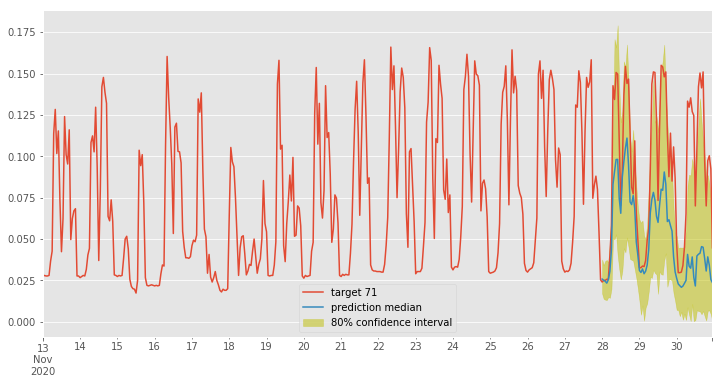

i: 72 sd083
RMSE: 0.02713808523011009
MAE: 0.023997590095037744
Target Mean: 0.03313888609409332
sMAPE: 1.1486947166854518
                     y_pred  y_label
2020-11-28 00:00:00   0.020    0.024
2020-11-28 01:00:00   0.019    0.024
2020-11-28 02:00:00   0.020    0.024
2020-11-28 03:00:00   0.016    0.018
2020-11-28 04:00:00   0.016    0.024
...                     ...      ...
2020-11-30 19:00:00   0.003    0.024
2020-11-30 20:00:00   0.004    0.024
2020-11-30 21:00:00   0.005    0.024
2020-11-30 22:00:00   0.004    0.024
2020-11-30 23:00:00   0.005    0.032

[72 rows x 2 columns]


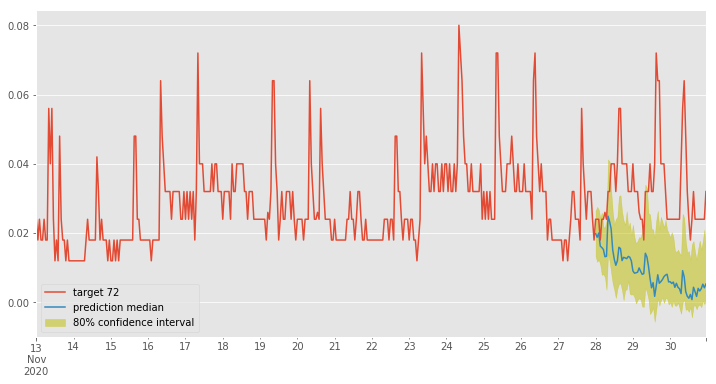

i: 73 sd084
RMSE: 0.02880210446817508
MAE: 0.026289433648611114
Target Mean: 0.0
sMAPE: 2.0
                     y_pred  y_label
2020-11-28 00:00:00  -0.019    0.000
2020-11-28 01:00:00  -0.024    0.000
2020-11-28 02:00:00  -0.020    0.000
2020-11-28 03:00:00  -0.028    0.000
2020-11-28 04:00:00  -0.028    0.000
...                     ...      ...
2020-11-30 19:00:00  -0.014    0.000
2020-11-30 20:00:00  -0.011    0.000
2020-11-30 21:00:00  -0.016    0.000
2020-11-30 22:00:00  -0.008    0.000
2020-11-30 23:00:00  -0.009    0.000

[72 rows x 2 columns]


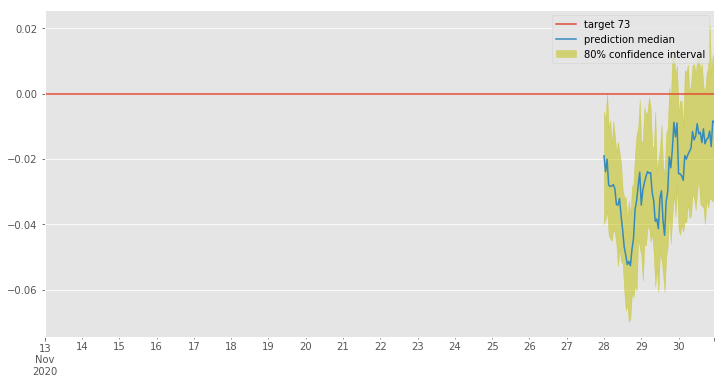

i: 74 sd085
RMSE: 0.1270266190739919
MAE: 0.08514772068272242
Target Mean: 0.1677500307559967
sMAPE: 0.6830790966154278
                     y_pred  y_label
2020-11-28 00:00:00   0.286    0.366
2020-11-28 01:00:00   0.282    0.384
2020-11-28 02:00:00   0.279    0.384
2020-11-28 03:00:00   0.250    0.402
2020-11-28 04:00:00   0.315    0.390
...                     ...      ...
2020-11-30 19:00:00   0.027    0.030
2020-11-30 20:00:00   0.024    0.024
2020-11-30 21:00:00   0.024    0.024
2020-11-30 22:00:00   0.037    0.024
2020-11-30 23:00:00   0.092    0.228

[72 rows x 2 columns]


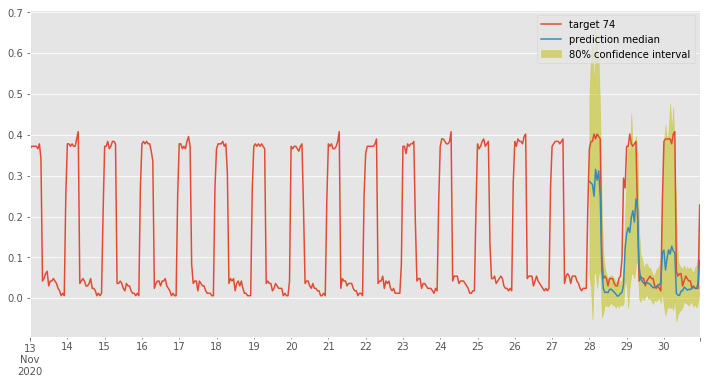

i: 75 sd086
RMSE: 0.06618968815863943
MAE: 0.05072815332231215
Target Mean: 0.12136110663414001
sMAPE: 0.453698679137651
                     y_pred  y_label
2020-11-28 00:00:00   0.088    0.044
2020-11-28 01:00:00   0.058    0.044
2020-11-28 02:00:00   0.038    0.034
2020-11-28 03:00:00   0.021    0.024
2020-11-28 04:00:00   0.022    0.018
...                     ...      ...
2020-11-30 19:00:00   0.161    0.094
2020-11-30 20:00:00   0.162    0.268
2020-11-30 21:00:00   0.181    0.228
2020-11-30 22:00:00   0.144    0.254
2020-11-30 23:00:00   0.129    0.213

[72 rows x 2 columns]


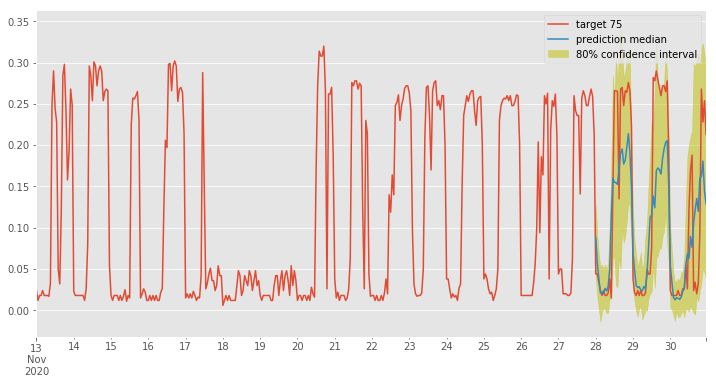

i: 76 sd087
RMSE: 0.041776173256130346
MAE: 0.0295250378063235
Target Mean: 0.034500014036893845
sMAPE: 1.244383692865442
                     y_pred  y_label
2020-11-28 00:00:00   0.009    0.008
2020-11-28 01:00:00   0.007    0.008
2020-11-28 02:00:00   0.008    0.008
2020-11-28 03:00:00   0.008    0.008
2020-11-28 04:00:00   0.007    0.004
...                     ...      ...
2020-11-30 19:00:00   0.004    0.040
2020-11-30 20:00:00   0.003    0.032
2020-11-30 21:00:00   0.003    0.032
2020-11-30 22:00:00   0.004    0.028
2020-11-30 23:00:00   0.001    0.012

[72 rows x 2 columns]


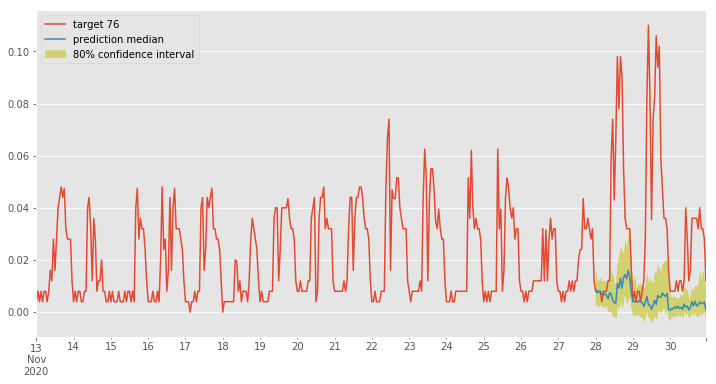

i: 77 sd088
RMSE: 0.008546429361744174
MAE: 0.006324584660420545
Target Mean: 0.027569446712732315
sMAPE: 0.2570004720739685
                     y_pred  y_label
2020-11-28 00:00:00   0.015    0.016
2020-11-28 01:00:00   0.016    0.017
2020-11-28 02:00:00   0.016    0.017
2020-11-28 03:00:00   0.016    0.017
2020-11-28 04:00:00   0.017    0.017
...                     ...      ...
2020-11-30 19:00:00   0.022    0.024
2020-11-30 20:00:00   0.019    0.027
2020-11-30 21:00:00   0.017    0.022
2020-11-30 22:00:00   0.018    0.020
2020-11-30 23:00:00   0.017    0.019

[72 rows x 2 columns]


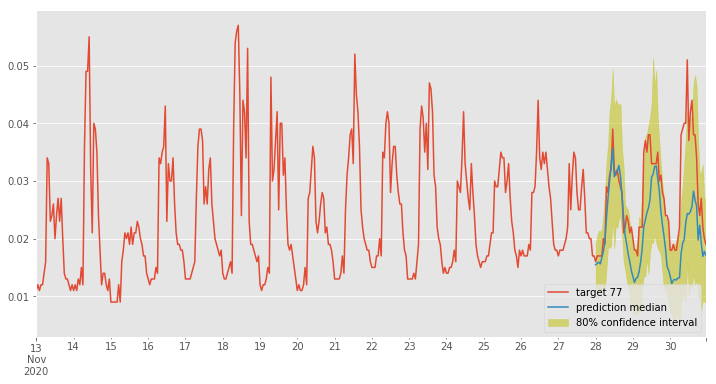

i: 78 sd089
RMSE: 0.1893888648537337
MAE: 0.14433395155148676
Target Mean: 0.15446525812149048
sMAPE: 1.6131849912932277
                     y_pred  y_label
2020-11-28 00:00:00   0.024    0.032
2020-11-28 01:00:00   0.019    0.032
2020-11-28 02:00:00   0.017    0.032
2020-11-28 03:00:00   0.017    0.040
2020-11-28 04:00:00   0.011    0.040
...                     ...      ...
2020-11-30 19:00:00   0.006    0.092
2020-11-30 20:00:00   0.008    0.092
2020-11-30 21:00:00   0.007    0.094
2020-11-30 22:00:00   0.008    0.084
2020-11-30 23:00:00   0.008    0.092

[72 rows x 2 columns]


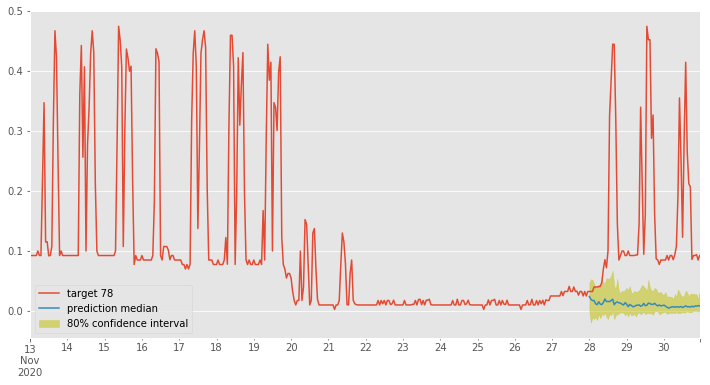

i: 79 sd090
RMSE: 0.0419636308282993
MAE: 0.034291954234594114
Target Mean: 0.04831364378333092
sMAPE: 0.5917733112501492
                     y_pred  y_label
2020-11-28 00:00:00   0.033    0.029
2020-11-28 01:00:00   0.028    0.028
2020-11-28 02:00:00   0.031    0.029
2020-11-28 03:00:00   0.033    0.029
2020-11-28 04:00:00   0.039    0.030
...                     ...      ...
2020-11-30 19:00:00   0.119    0.080
2020-11-30 20:00:00   0.096    0.031
2020-11-30 21:00:00   0.077    0.020
2020-11-30 22:00:00   0.069    0.018
2020-11-30 23:00:00   0.057    0.035

[72 rows x 2 columns]


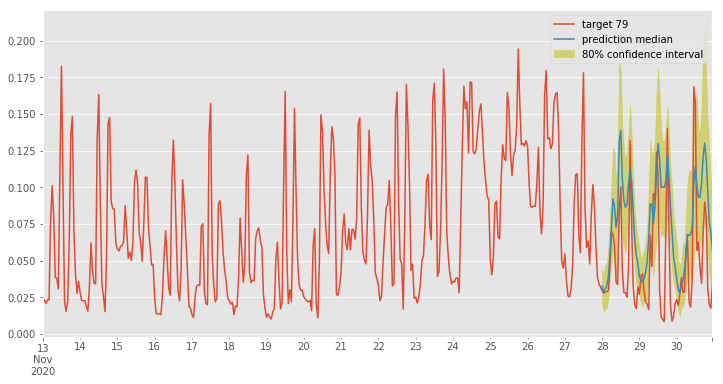

i: 80 sd091
RMSE: 0.2566412172615904
MAE: 0.19018568512233205
Target Mean: 0.2343749701976776
sMAPE: 0.8215565008094798
                     y_pred  y_label
2020-11-28 00:00:00   0.490    0.675
2020-11-28 01:00:00   0.502    0.705
2020-11-28 02:00:00   0.528    0.690
2020-11-28 03:00:00   0.478    0.540
2020-11-28 04:00:00   0.466    0.270
...                     ...      ...
2020-11-30 19:00:00   0.255    0.255
2020-11-30 20:00:00   0.232    0.255
2020-11-30 21:00:00   0.261    0.255
2020-11-30 22:00:00   0.301    0.255
2020-11-30 23:00:00   0.396    0.255

[72 rows x 2 columns]


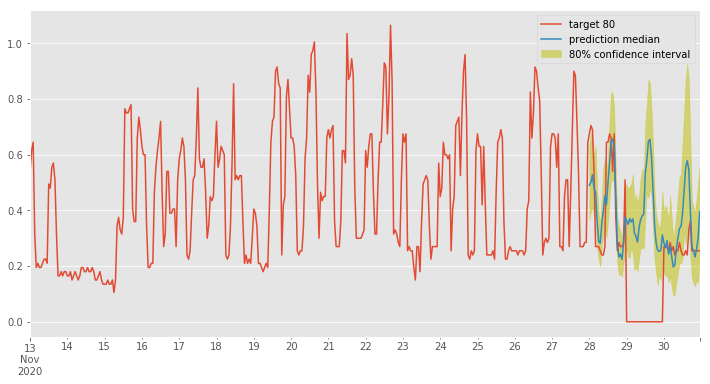

i: 81 sd092
RMSE: 0.04895305485265596
MAE: 0.043422027593577196
Target Mean: 0.06138889491558075
sMAPE: 0.9615487049700314
                     y_pred  y_label
2020-11-28 00:00:00   0.084    0.094
2020-11-28 01:00:00   0.081    0.095
2020-11-28 02:00:00   0.078    0.094
2020-11-28 03:00:00   0.074    0.090
2020-11-28 04:00:00   0.072    0.076
...                     ...      ...
2020-11-30 19:00:00   0.045    0.095
2020-11-30 20:00:00   0.046    0.101
2020-11-30 21:00:00   0.053    0.100
2020-11-30 22:00:00   0.053    0.112
2020-11-30 23:00:00   0.055    0.097

[72 rows x 2 columns]


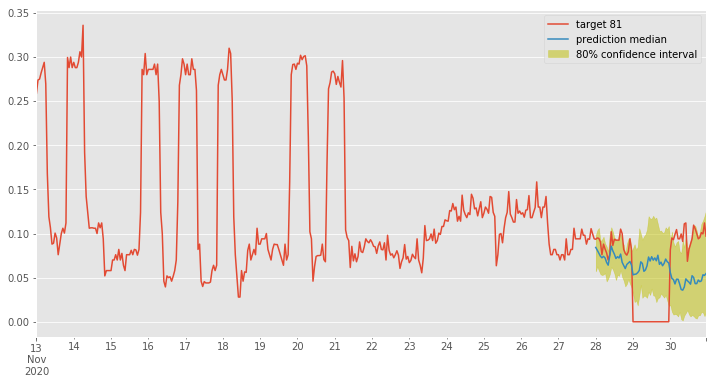

i: 82 sd093
RMSE: 0.028932133892497214
MAE: 0.020942570451306524
Target Mean: 0.010555552318692207
sMAPE: 1.0659218722024328
                     y_pred  y_label
2020-11-28 00:00:00   0.011    0.010
2020-11-28 01:00:00   0.009    0.020
2020-11-28 02:00:00   0.011    0.010
2020-11-28 03:00:00   0.005    0.010
2020-11-28 04:00:00   0.005    0.020
...                     ...      ...
2020-11-30 19:00:00   0.014    0.020
2020-11-30 20:00:00   0.015    0.010
2020-11-30 21:00:00   0.016    0.020
2020-11-30 22:00:00   0.013    0.010
2020-11-30 23:00:00   0.019    0.020

[72 rows x 2 columns]


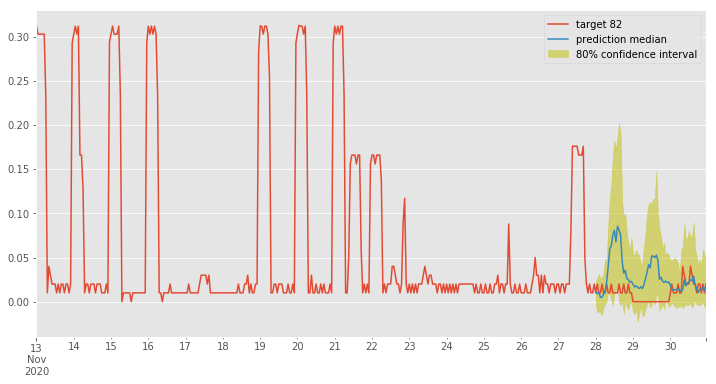

i: 83 sd094
RMSE: 0.07221875107607365
MAE: 0.05470433399400516
Target Mean: 0.07724998146295547
sMAPE: 0.9598653643502082
                     y_pred  y_label
2020-11-28 00:00:00   0.040    0.054
2020-11-28 01:00:00   0.038    0.042
2020-11-28 02:00:00   0.037    0.042
2020-11-28 03:00:00   0.035    0.042
2020-11-28 04:00:00   0.039    0.048
...                     ...      ...
2020-11-30 19:00:00   0.066    0.114
2020-11-30 20:00:00   0.056    0.096
2020-11-30 21:00:00   0.054    0.078
2020-11-30 22:00:00   0.044    0.072
2020-11-30 23:00:00   0.046    0.066

[72 rows x 2 columns]


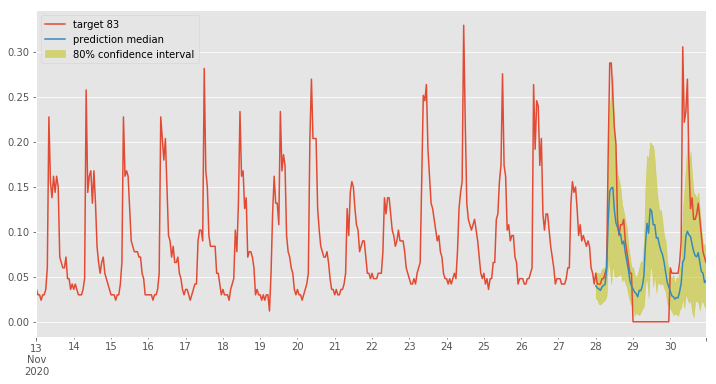

i: 84 sd095
RMSE: 2.5752530283002653
MAE: 1.993513037765449
Target Mean: 3.229750156402588
sMAPE: 0.8196652928604296
                     y_pred  y_label
2020-11-28 00:00:00   2.540    2.714
2020-11-28 01:00:00   2.407    2.714
2020-11-28 02:00:00   2.278    2.504
2020-11-28 03:00:00   2.281    2.504
2020-11-28 04:00:00   2.408    2.504
...                     ...      ...
2020-11-30 19:00:00   4.004    3.554
2020-11-30 20:00:00   3.947    3.344
2020-11-30 21:00:00   3.853    3.344
2020-11-30 22:00:00   3.707    3.134
2020-11-30 23:00:00   3.786    3.134

[72 rows x 2 columns]


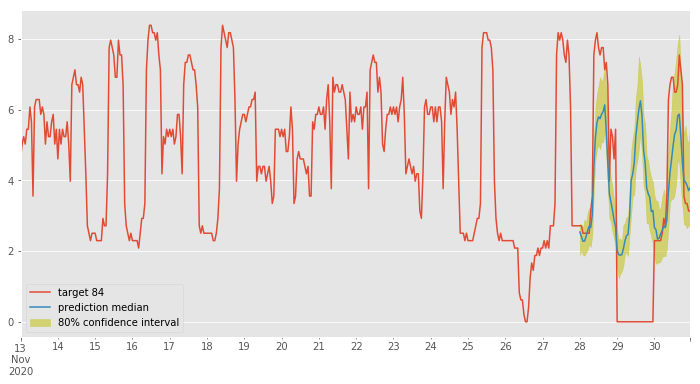

i: 85 sd096
RMSE: 0.022818996464107476
MAE: 0.02112064142568429
Target Mean: 0.03149999678134918
sMAPE: 0.9658177788650275
                     y_pred  y_label
2020-11-28 00:00:00   0.023    0.036
2020-11-28 01:00:00   0.025    0.036
2020-11-28 02:00:00   0.028    0.036
2020-11-28 03:00:00   0.024    0.036
2020-11-28 04:00:00   0.030    0.046
...                     ...      ...
2020-11-30 19:00:00   0.023    0.046
2020-11-30 20:00:00   0.027    0.046
2020-11-30 21:00:00   0.031    0.046
2020-11-30 22:00:00   0.028    0.046
2020-11-30 23:00:00   0.029    0.046

[72 rows x 2 columns]


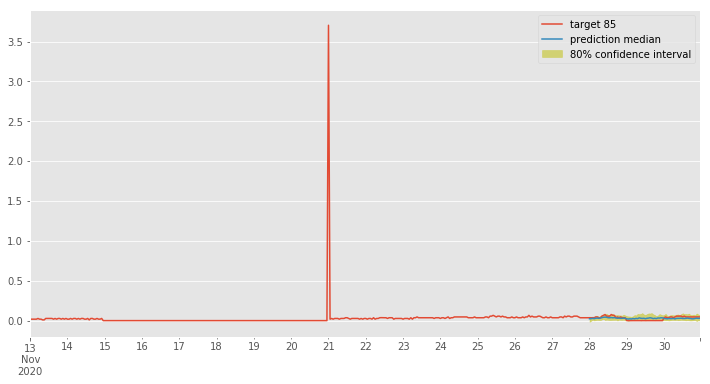

i: 86 sd097
RMSE: 0.3748698144759414
MAE: 0.2558664270811788
Target Mean: 0.37884724140167236
sMAPE: 0.8939054674899596
                     y_pred  y_label
2020-11-28 00:00:00   0.050    0.118
2020-11-28 01:00:00   0.076    0.059
2020-11-28 02:00:00   0.073    0.118
2020-11-28 03:00:00   0.089    0.059
2020-11-28 04:00:00   0.101    0.059
...                     ...      ...
2020-11-30 19:00:00   0.727    1.016
2020-11-30 20:00:00   0.407    0.476
2020-11-30 21:00:00   0.215    0.177
2020-11-30 22:00:00   0.125    0.118
2020-11-30 23:00:00   0.138    0.118

[72 rows x 2 columns]


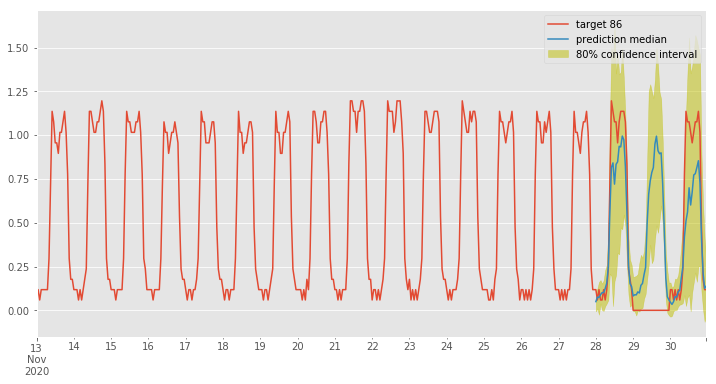

i: 87 sd098
RMSE: 0.07426439949521225
MAE: 0.05015564787023917
Target Mean: 0.05712500587105751
sMAPE: 1.3072225228739287
                     y_pred  y_label
2020-11-28 00:00:00   0.011    0.009
2020-11-28 01:00:00   0.010    0.018
2020-11-28 02:00:00   0.013    0.009
2020-11-28 03:00:00   0.010    0.018
2020-11-28 04:00:00   0.011    0.009
...                     ...      ...
2020-11-30 19:00:00  -0.004    0.009
2020-11-30 20:00:00  -0.001    0.018
2020-11-30 21:00:00   0.001    0.009
2020-11-30 22:00:00   0.003    0.009
2020-11-30 23:00:00   0.003    0.018

[72 rows x 2 columns]


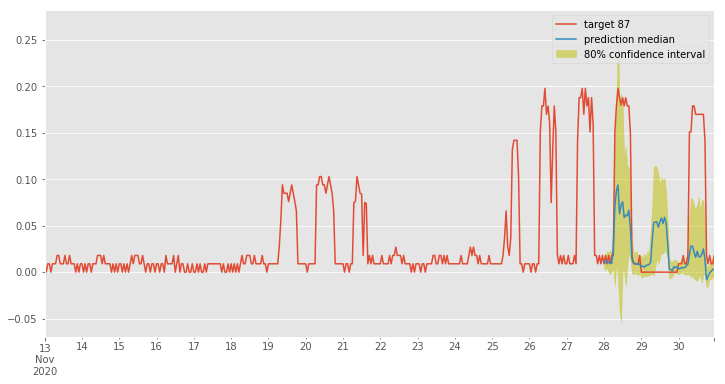

i: 88 sd099
RMSE: 0.18945351871322197
MAE: 0.15561611733355343
Target Mean: 0.1585139036178589
sMAPE: 1.1966976324842475
                     y_pred  y_label
2020-11-28 00:00:00   0.208    0.038
2020-11-28 01:00:00   0.160    0.019
2020-11-28 02:00:00   0.149    0.038
2020-11-28 03:00:00   0.136    0.038
2020-11-28 04:00:00   0.104    0.038
...                     ...      ...
2020-11-30 19:00:00   0.159    0.504
2020-11-30 20:00:00   0.167    0.464
2020-11-30 21:00:00   0.215    0.504
2020-11-30 22:00:00   0.207    0.407
2020-11-30 23:00:00   0.156    0.057

[72 rows x 2 columns]


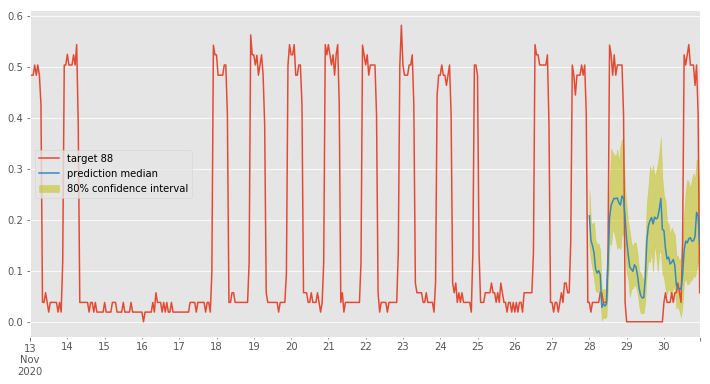

i: 89 sd100
RMSE: 0.498767040471734
MAE: 0.443378633922673
Target Mean: 1.818055510520935
sMAPE: 0.28619381957247414
                     y_pred  y_label
2020-11-28 00:00:00   1.658    1.680
2020-11-28 01:00:00   1.613    1.820
2020-11-28 02:00:00   1.475    1.540
2020-11-28 03:00:00   1.411    1.680
2020-11-28 04:00:00   1.378    1.680
...                     ...      ...
2020-11-30 19:00:00   1.544    1.960
2020-11-30 20:00:00   1.600    1.820
2020-11-30 21:00:00   1.610    1.820
2020-11-30 22:00:00   1.477    1.960
2020-11-30 23:00:00   1.501    1.960

[72 rows x 2 columns]


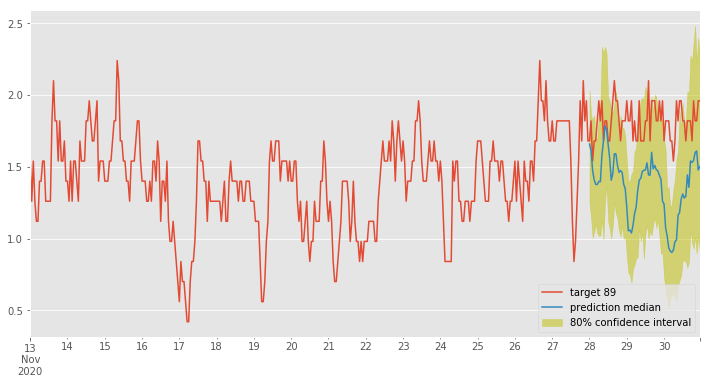

i: 90 sd101
RMSE: 0.40466126749450787
MAE: 0.33258108463836716
Target Mean: 1.3609999418258667
sMAPE: 0.2785459531392773
                     y_pred  y_label
2020-11-28 00:00:00   1.206    1.316
2020-11-28 01:00:00   1.202    1.156
2020-11-28 02:00:00   1.163    1.196
2020-11-28 03:00:00   1.181    1.316
2020-11-28 04:00:00   1.223    1.240
...                     ...      ...
2020-11-30 19:00:00   1.220    1.508
2020-11-30 20:00:00   1.343    1.548
2020-11-30 21:00:00   1.197    1.460
2020-11-30 22:00:00   1.180    1.352
2020-11-30 23:00:00   1.175    1.508

[72 rows x 2 columns]


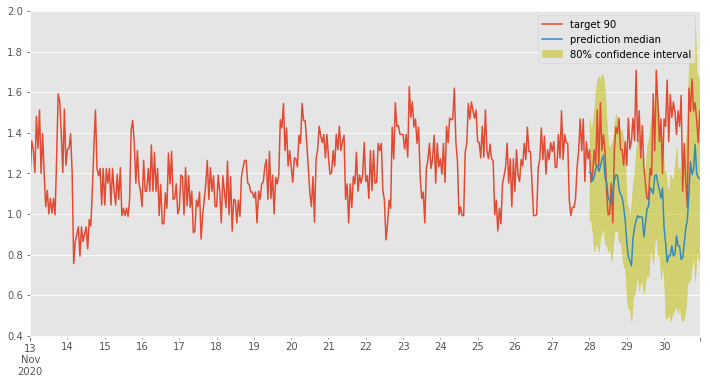

i: 91 sd102
RMSE: 0.24151226894529146
MAE: 0.15076166564558402
Target Mean: 0.30250006914138794
sMAPE: 0.5997778197923559
                     y_pred  y_label
2020-11-28 00:00:00   0.042    0.060
2020-11-28 01:00:00   0.054    0.060
2020-11-28 02:00:00   0.054    0.060
2020-11-28 03:00:00   0.047    0.060
2020-11-28 04:00:00   0.054    0.060
...                     ...      ...
2020-11-30 19:00:00   0.044    0.150
2020-11-30 20:00:00   0.016    0.090
2020-11-30 21:00:00   0.011    0.090
2020-11-30 22:00:00   0.018    0.060
2020-11-30 23:00:00   0.020    0.060

[72 rows x 2 columns]


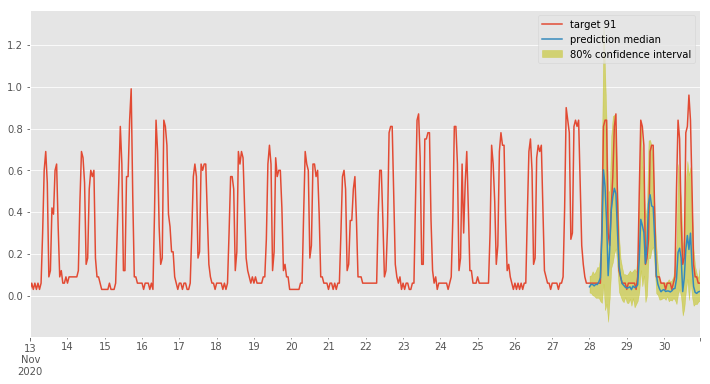

i: 92 sd103
RMSE: 0.045724993562037644
MAE: 0.02198534167361185
Target Mean: 0.023499980568885803
sMAPE: 1.1102918434310864
                     y_pred  y_label
2020-11-28 00:00:00   0.005    0.000
2020-11-28 01:00:00   0.007    0.009
2020-11-28 02:00:00   0.004    0.009
2020-11-28 03:00:00   0.004    0.000
2020-11-28 04:00:00   0.005    0.018
...                     ...      ...
2020-11-30 19:00:00   0.002    0.009
2020-11-30 20:00:00   0.005    0.009
2020-11-30 21:00:00   0.004    0.000
2020-11-30 22:00:00   0.003    0.009
2020-11-30 23:00:00   0.005    0.009

[72 rows x 2 columns]


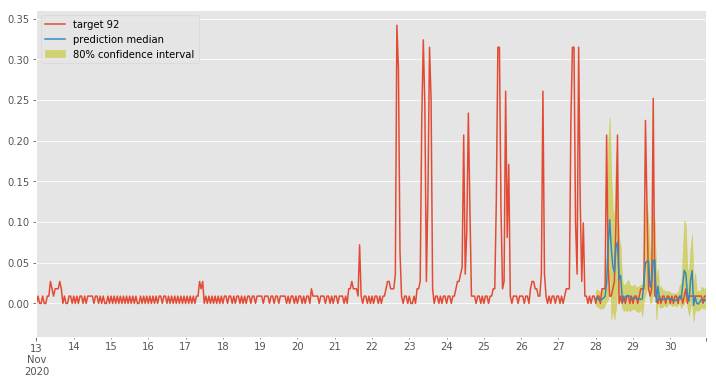

i: 93 sd104
RMSE: 0.004028817467671394
MAE: 0.00329817212029211
Target Mean: 0.01963888108730316
sMAPE: 0.1783796253737065
                     y_pred  y_label
2020-11-28 00:00:00   0.017    0.018
2020-11-28 01:00:00   0.017    0.016
2020-11-28 02:00:00   0.017    0.018
2020-11-28 03:00:00   0.017    0.018
2020-11-28 04:00:00   0.017    0.016
...                     ...      ...
2020-11-30 19:00:00   0.017    0.022
2020-11-30 20:00:00   0.018    0.022
2020-11-30 21:00:00   0.017    0.022
2020-11-30 22:00:00   0.017    0.022
2020-11-30 23:00:00   0.017    0.020

[72 rows x 2 columns]


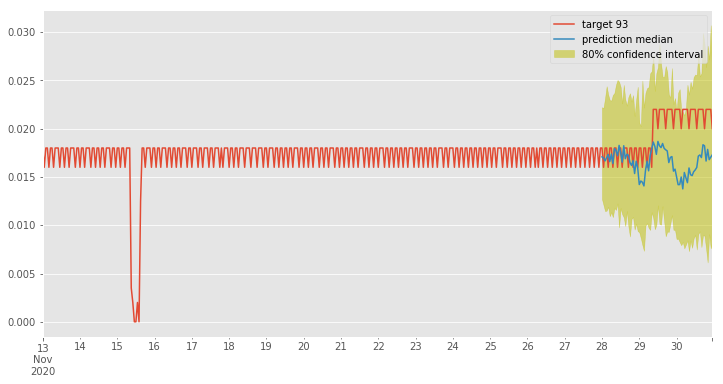

i: 94 sd105
RMSE: 0.010927336019086175
MAE: 0.009777666217833207
Target Mean: 0.010027775540947914
sMAPE: 1.5509425406839532
                     y_pred  y_label
2020-11-28 00:00:00   0.008    0.000
2020-11-28 01:00:00   0.014    0.019
2020-11-28 02:00:00   0.007    0.000
2020-11-28 03:00:00   0.013    0.019
2020-11-28 04:00:00   0.010    0.000
...                     ...      ...
2020-11-30 19:00:00   0.004    0.000
2020-11-30 20:00:00   0.002    0.000
2020-11-30 21:00:00   0.002    0.019
2020-11-30 22:00:00   0.002    0.000
2020-11-30 23:00:00   0.003    0.019

[72 rows x 2 columns]


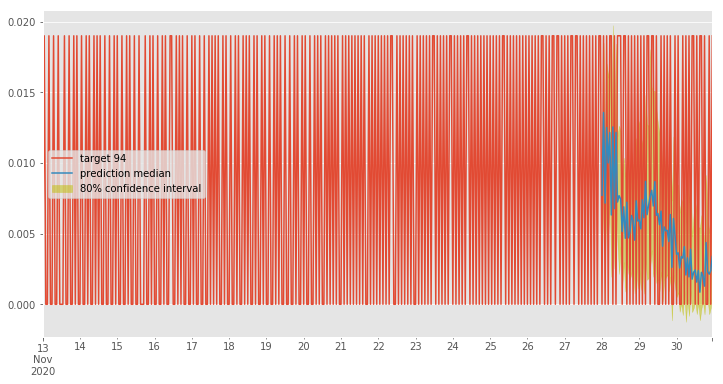

i: 95 sd106
RMSE: 0.2640014228926519
MAE: 0.1736646498947841
Target Mean: 0.1942499279975891
sMAPE: 1.0702086131807098
                     y_pred  y_label
2020-11-28 00:00:00   0.046    0.036
2020-11-28 01:00:00   0.048    0.072
2020-11-28 02:00:00   0.045    0.090
2020-11-28 03:00:00   0.041    0.072
2020-11-28 04:00:00   0.042    0.090
...                     ...      ...
2020-11-30 19:00:00   0.025    0.018
2020-11-30 20:00:00   0.027    0.018
2020-11-30 21:00:00   0.033    0.018
2020-11-30 22:00:00   0.029    0.018
2020-11-30 23:00:00   0.036    0.018

[72 rows x 2 columns]


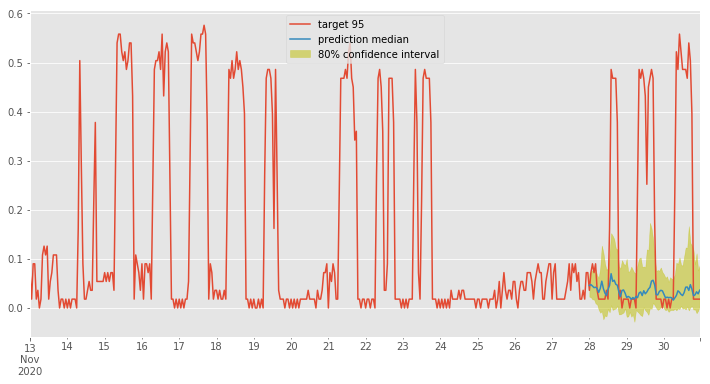

CPU times: user 39.9 s, sys: 17.5 s, total: 57.4 s
Wall time: 22.8 s


In [58]:
%%time
from sklearn import metrics

def show_metrics(target_quantile='0.5'):
    for i in range(len(timeseries)):
        if preds[i] is None:
            continue
        
        s = timeseries[i][start_dataset:end_predict].fillna(0)
#         s = timeseries[i][end_predict-timedelta(days=context_length+prediction_length+1):end_predict-timedelta(days=1)].fillna(0)
#         s = timeseries[i][end_predict-timedelta(days=30+1):end_predict].fillna(0)
        
        print("i:", i, ids[i])
        p10 = preds[i]['0.1']
        p90 = preds[i]['0.9']
        y_label =  timeseries[i][start_predict:end_predict].fillna(0)
        y_pred = preds[i][target_quantile]
        if y_label.shape[0] != y_pred.shape[0]:
            continue
        
        print("RMSE:",np.sqrt(metrics.mean_squared_error(y_label, y_pred)))
        print("MAE:",metrics.mean_absolute_error(y_label, y_pred))
        print("Target Mean:",y_label.mean())
        print("sMAPE:",smape(y_label, y_pred))
        print(pd.DataFrame({'y_pred': y_pred, 'y_label': y_label}))
        plt.figure(figsize=(12,6))
        s.plot(label='target %s'%str(i))
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        y_pred.plot(label='prediction median')
        plt.legend()
        plt.show()

show_metrics(target_quantile=target_quantile)

Below we define a plotting function that queries the model and displays the forecast.

In [59]:
days_in_freq = 1
if freq == '1M':
    days_in_freq = 30  # TODO not exactly correct

In [63]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=30,
    confidence=80
):
#     print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date][:-1],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }
#     print(len(target_ts[:forecast_date-timedelta(days=1)]))
#     print('dynamic_feat:', len(dynamic_feat[0]), len(dynamic_feat[1]))

    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
    # plot the target
    target_section = target_ts[forecast_date-timedelta(days=plot_history):]  # forecast_date+timedelta(days=prediction_length*days_in_freq)
#     print('target_section:', len(target_section), target_section)
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
#     print('prediction["0.5"]:', prediction["0.5"])
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            new_ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
#             print('feat_ts:', feat_ts)
            feat_ts[forecast_date-timedelta(days=plot_history):].plot(ax=new_ax, color='g')  # forecast_date+timedelta(days=prediction_length)

In [64]:
style = {'description_width': 'initial'}

In [65]:
@interact_manual(
    idx=IntSlider(min=0, max=num_timeseries-1, value=0, style=style), 
    forecast_day=IntSlider(min=0, max=0, value=0, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_days_plot=IntSlider(min=1, max=context_length*days_in_freq, value=context_length*days_in_freq, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(idx, forecast_day, confidence, history_days_plot, show_samples):
    dynamic_feat = []
    for dynamic_featj in dynamic_feats[idx]:
        dynamic_feat.append(dynamic_featj[start_dataset:end_predict].tolist())
    plot(
        predictor,
        target_ts=timeseries[idx],
        cat=property_cat[idx],
        dynamic_feat=dynamic_feat,
        forecast_date=end_test,
        show_samples=show_samples,
        plot_history=history_days_plot,
        confidence=confidence
    )

interactive(children=(IntSlider(value=0, description='idx', max=95, style=SliderStyle(description_width='initi…

### Delete endpoints

In [66]:
predictor.delete_endpoint()